In [1]:
import sys

sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain")
sys.path.append("c:\\Users\\robin\\Documents\\HyperBrain\\source")

In [2]:
from source.datasets.brain_dataset import BrainDataset
from source.loftr.backbone import ResNetFPN_16_4
from source.loftr.positional_encoding import PositionalEncoding
from source.loftr.transformer import LocalFeatureTransformer
from source.loftr.coarse_matching import CoarseMatching
from source.loftr.fine_matching import FineMatching
from source.loftr.fine_preprocess import FinePreprocess
from source.loftr.loss import *
from source.visualization.evaluation_visualization import plot_loss_curve
from source.visualization.training_visualization import plot_grad_flow_hist
from torch.utils.data import DataLoader
from torchvision.transforms import v2
import time
import torch
from source.miscellaneous.evaluation import evaluate_model
from einops.einops import rearrange

In [3]:
torch.autograd.set_detect_anomaly(True)

In [4]:
crop_size = 640
transformation_threshold = 0.3
patch_size = 16
max_translation_shift = 50
fine_feature_size = 160
images_directory = "../../data/cyto_downscaled_3344_3904/"
use_train_data = False

dataset_train = BrainDataset(
    images_directory=images_directory,
    train=use_train_data,
    transformation_threshold=transformation_threshold,
    crop_size=crop_size,
    patch_size=patch_size,
    max_translation_shift=max_translation_shift,
    fine_feature_size=fine_feature_size,
    transform=v2.Compose([v2.Normalize(mean=[0.594], std=[0.204])]),
)

In [5]:
from source.datasets.brain_dataset import collate_fn

In [6]:
batch_size = 2

dataloader_train = DataLoader(
    dataset=dataset_train,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=False,
    drop_last=False,
    collate_fn=collate_fn,
)

In [3]:
learning_rate = 0.0007
weight_decay = 0.0015
use_coarse_context = False
clamp_predictions = True
use_l2_with_standard_deviation = False
temperature = (
    0.2  # Dont decrease this value, it will yield in overflows (similarity_matrix)
)

device = "cuda" if torch.cuda.is_available() else "cpu"

block_dimensions = [64, 96, 128, 192]
fine_feature_size = block_dimensions[1]
coarse_feature_size = block_dimensions[-1]
backbone = ResNetFPN_16_4(block_dimensions=block_dimensions).to(device=device)

positional_encoding = PositionalEncoding(coarse_feature_size).to(device=device)

coarse_loftr = LocalFeatureTransformer(
    feature_dimension=coarse_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"] * 4,
).to(device=device)

coarse_matcher = CoarseMatching(temperature=temperature, confidence_threshold=0.2).to(
    device=device
)

fine_preprocess = FinePreprocess(
    coarse_feature_size=coarse_feature_size,
    fine_feature_size=fine_feature_size,
    window_size=5,
    use_coarse_context=use_coarse_context,
).to(device=device)
fine_loftr = LocalFeatureTransformer(
    feature_dimension=fine_feature_size,
    number_of_heads=8,
    layer_names=["self", "cross"],
).to(device=device)
fine_matching = FineMatching(
    return_standard_deviation=use_l2_with_standard_deviation,
    clamp_predictions=clamp_predictions,
).to(device=device)

params = list(backbone.parameters()) + list(coarse_loftr.parameters())
optimizer = torch.optim.Adam(params, weight_decay=weight_decay, lr=learning_rate)

coarse_loss_history = []
fine_loss_history = []
loss_hist_test = []

In [8]:
coarse_loss = "focal"
alpha = 0.55
gamma = 1.5
fine_loss = "l2_std" if use_l2_with_standard_deviation else "l2"

In [9]:
seen_datapoints = 0

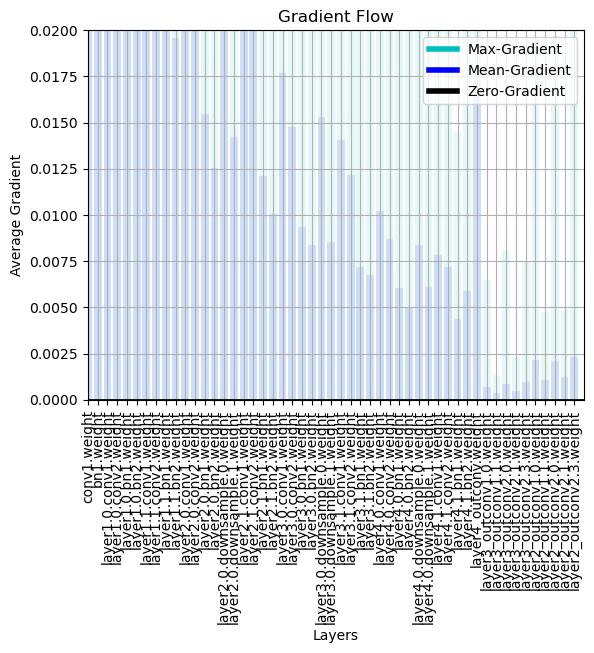

Epoch: 0, Duration: 5.33 sec, Latest Coarse Loss: 8.7436, Latest Fine Loss: 0.7666


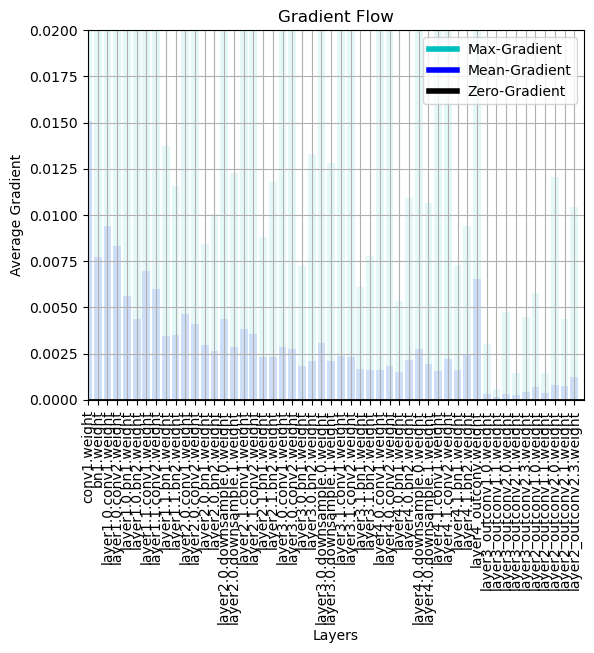

Epoch: 5, Duration: 3.43 sec, Latest Coarse Loss: 6.5265, Latest Fine Loss: 0.7430


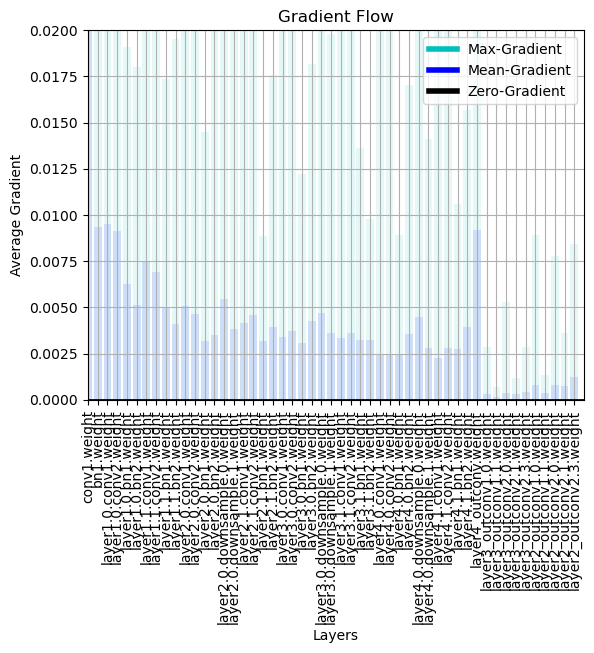

Epoch: 10, Duration: 3.06 sec, Latest Coarse Loss: 6.0472, Latest Fine Loss: 0.7129


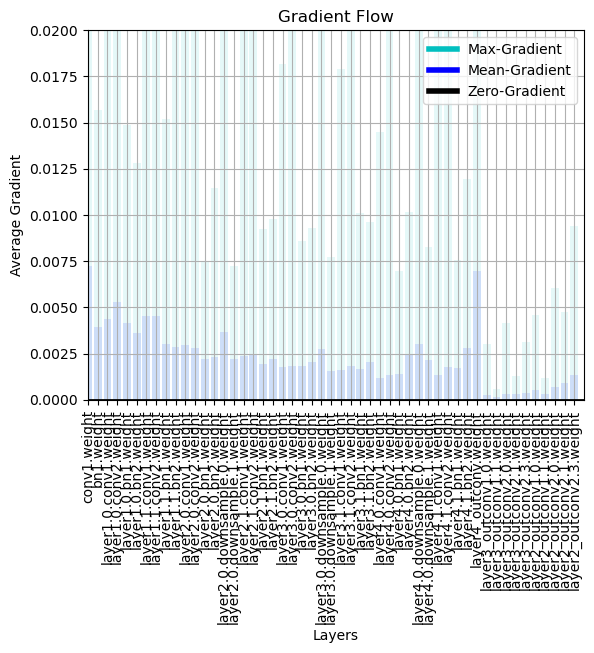

Epoch: 15, Duration: 3.15 sec, Latest Coarse Loss: 4.9940, Latest Fine Loss: 0.6580


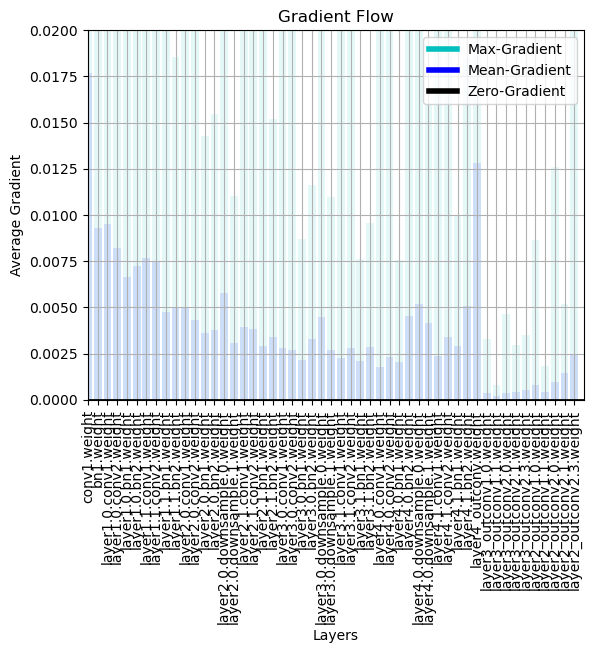

Epoch: 20, Duration: 3.05 sec, Latest Coarse Loss: 6.2647, Latest Fine Loss: 0.6879


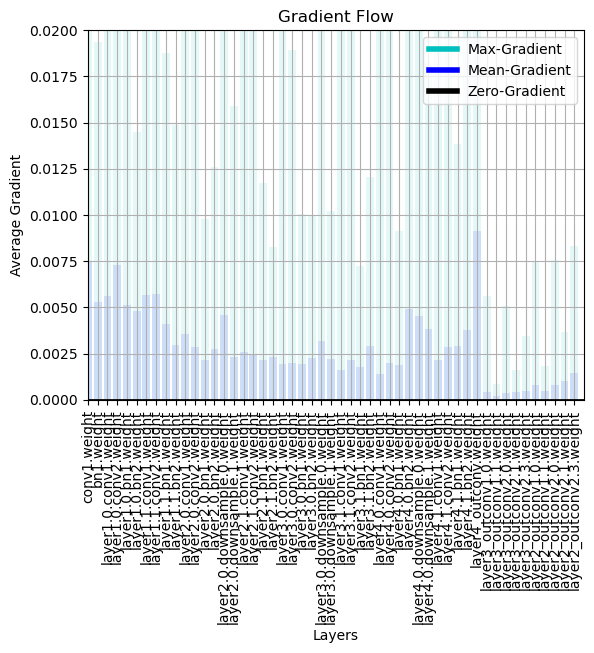

Epoch: 25, Duration: 3.19 sec, Latest Coarse Loss: 5.4693, Latest Fine Loss: 0.6399


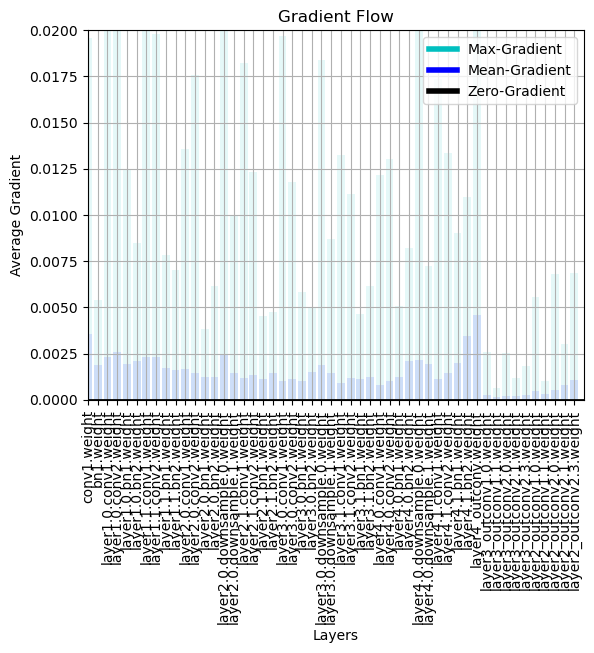

Epoch: 30, Duration: 3.41 sec, Latest Coarse Loss: 4.4853, Latest Fine Loss: 0.5630


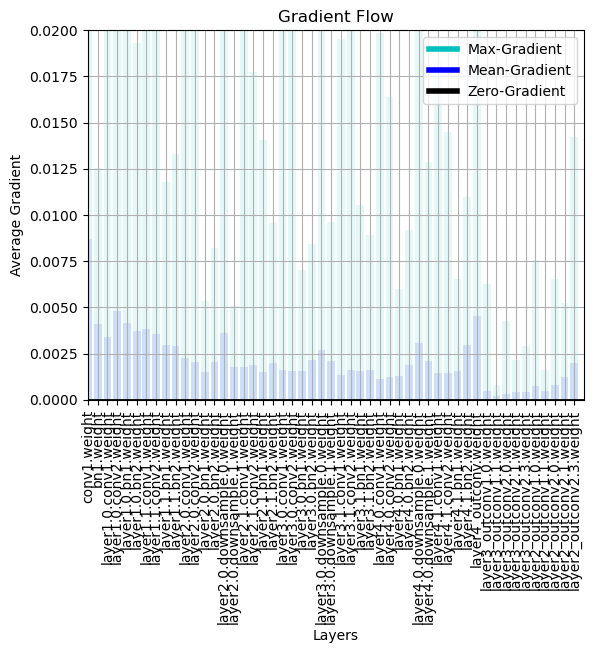

Epoch: 35, Duration: 4.15 sec, Latest Coarse Loss: 4.3765, Latest Fine Loss: 0.6174


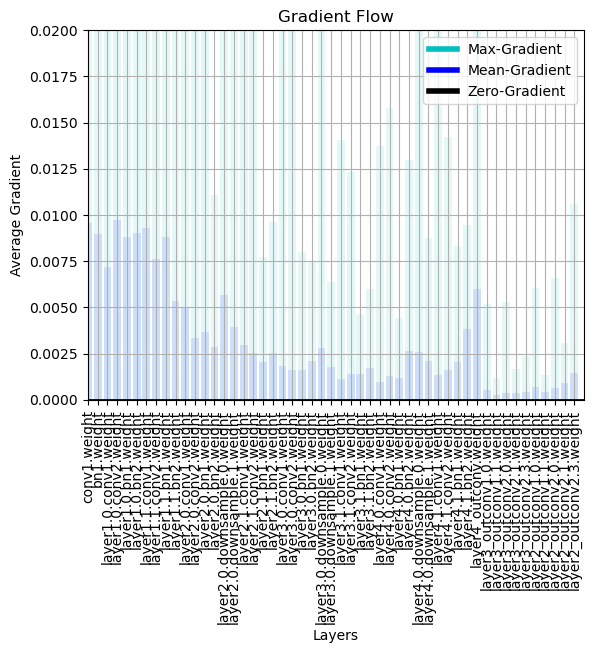

Epoch: 40, Duration: 3.39 sec, Latest Coarse Loss: 4.1004, Latest Fine Loss: 0.5840


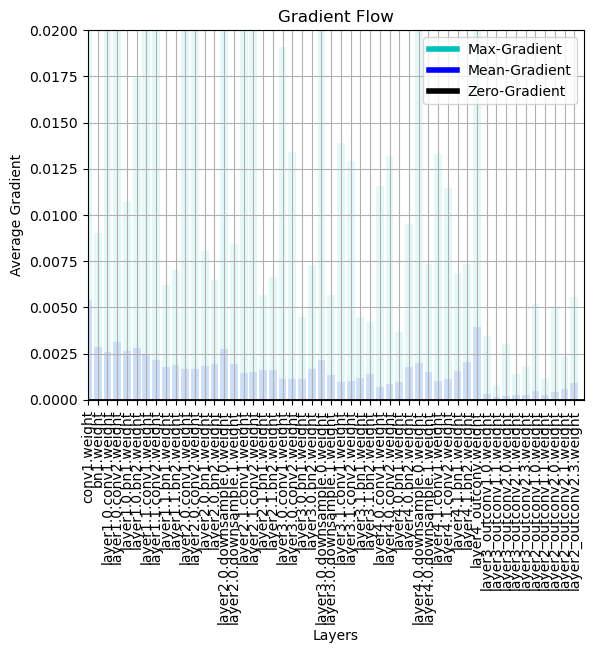

Epoch: 45, Duration: 3.10 sec, Latest Coarse Loss: 4.1318, Latest Fine Loss: 0.5717


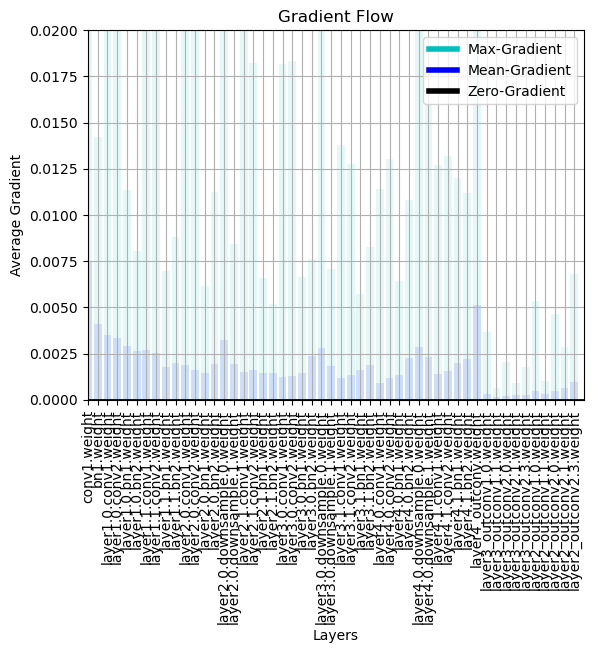

Epoch: 50, Duration: 3.20 sec, Latest Coarse Loss: 3.9531, Latest Fine Loss: 0.5066


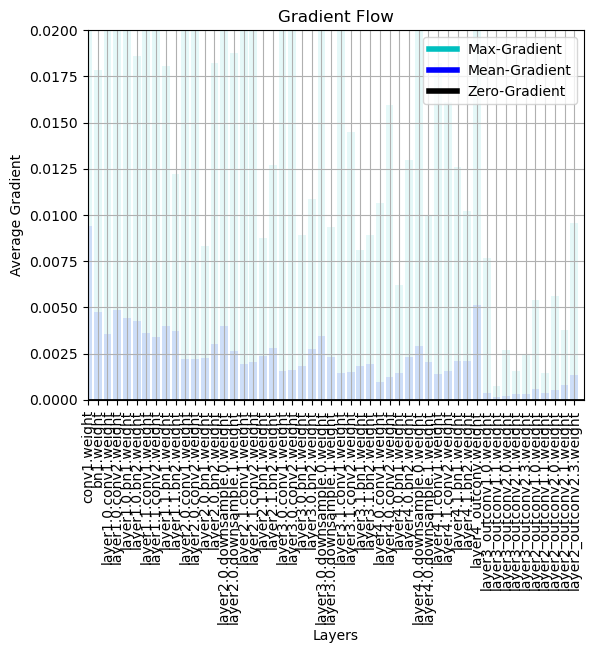

Epoch: 55, Duration: 3.13 sec, Latest Coarse Loss: 4.5118, Latest Fine Loss: 0.5590


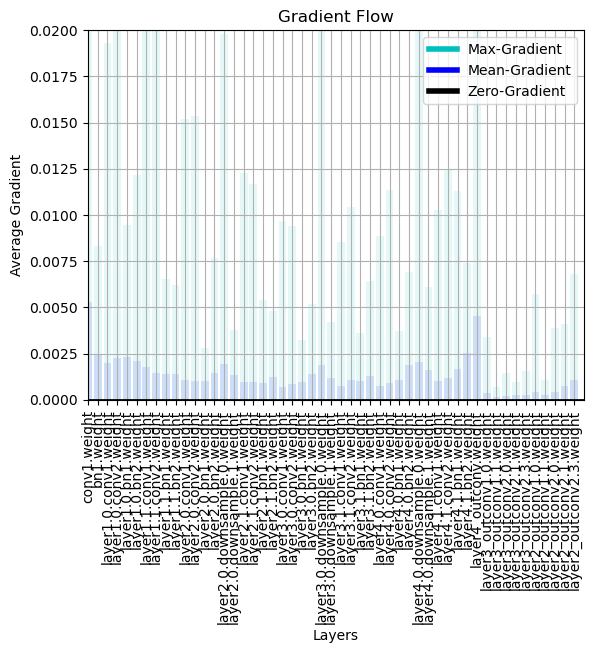

Epoch: 60, Duration: 3.12 sec, Latest Coarse Loss: 3.4112, Latest Fine Loss: 0.4838


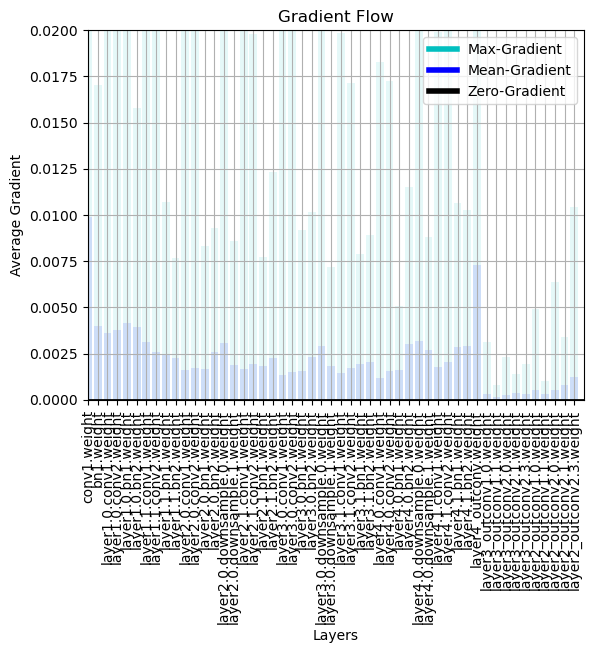

Epoch: 65, Duration: 3.18 sec, Latest Coarse Loss: 4.0546, Latest Fine Loss: 0.5302


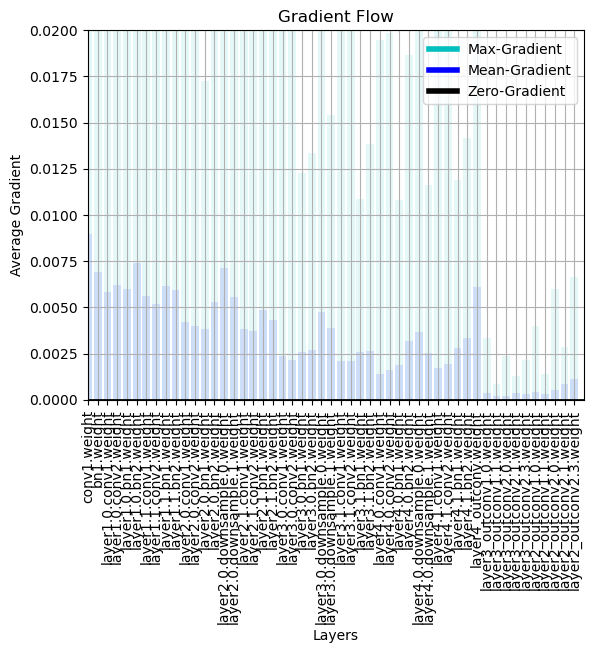

Epoch: 70, Duration: 3.19 sec, Latest Coarse Loss: 4.2472, Latest Fine Loss: 0.5102


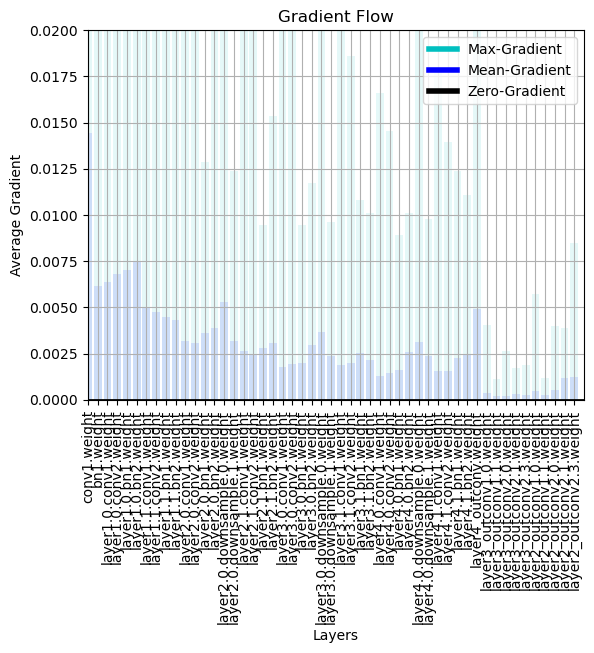

Epoch: 75, Duration: 3.23 sec, Latest Coarse Loss: 3.9133, Latest Fine Loss: 0.5986


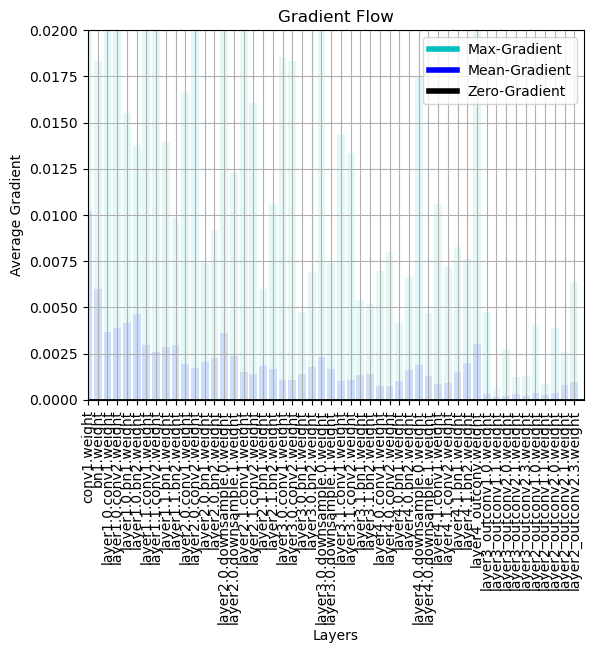

Epoch: 80, Duration: 3.27 sec, Latest Coarse Loss: 2.8255, Latest Fine Loss: 0.4715


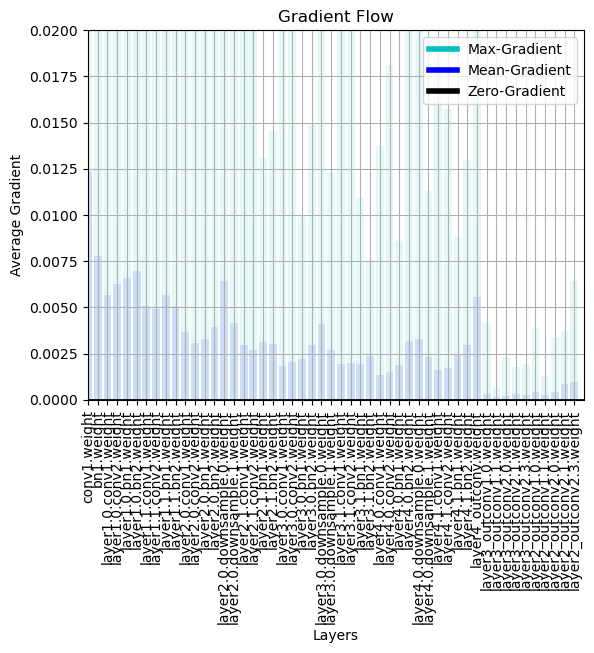

Epoch: 85, Duration: 3.16 sec, Latest Coarse Loss: 3.2226, Latest Fine Loss: 0.4808


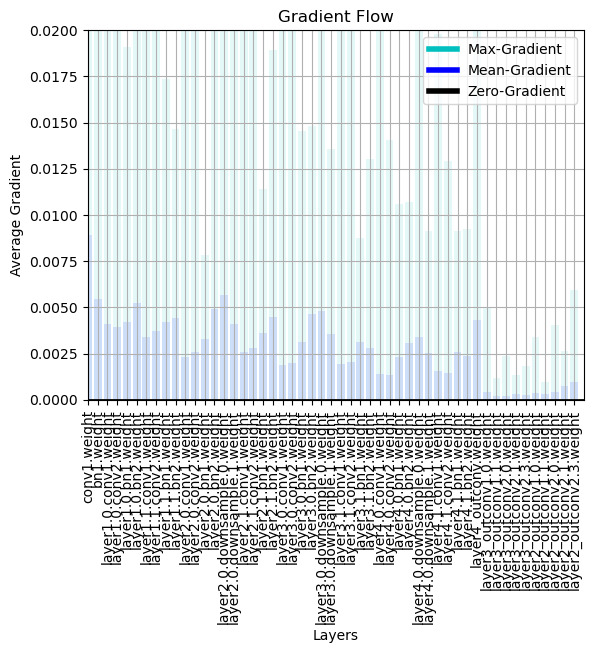

Epoch: 90, Duration: 3.10 sec, Latest Coarse Loss: 3.8035, Latest Fine Loss: 0.4146


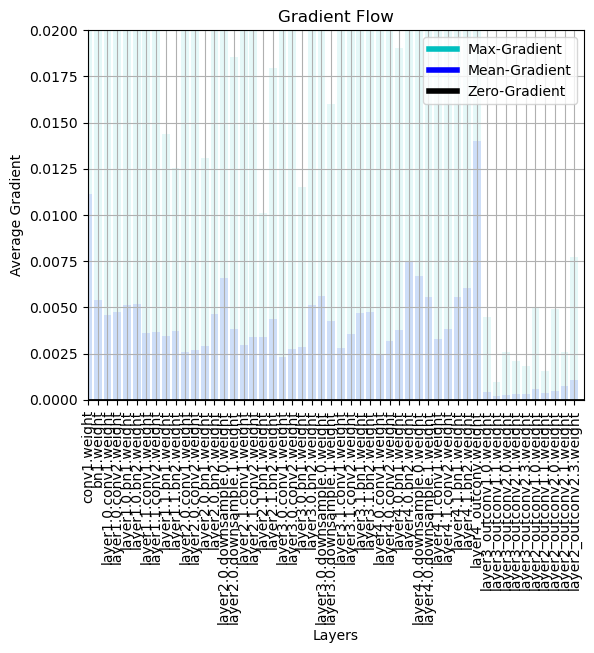

Epoch: 95, Duration: 3.11 sec, Latest Coarse Loss: 5.0707, Latest Fine Loss: 0.4720


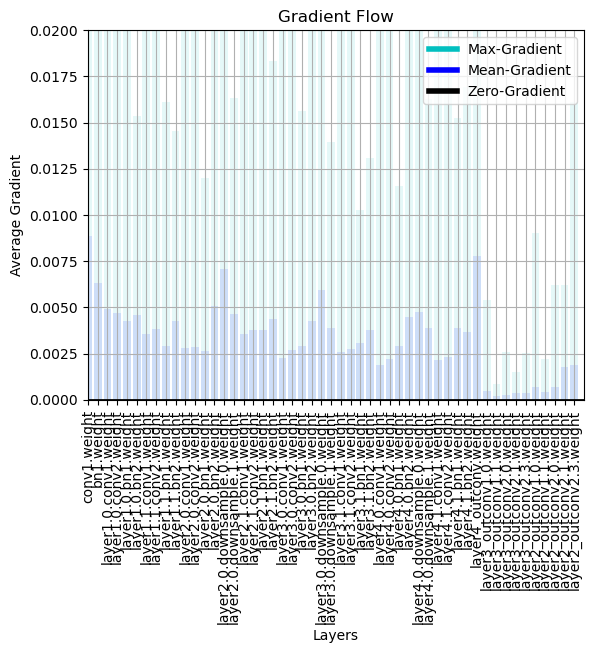

Epoch: 99, Duration: 3.17 sec, Latest Coarse Loss: 4.5430, Latest Fine Loss: 0.6231


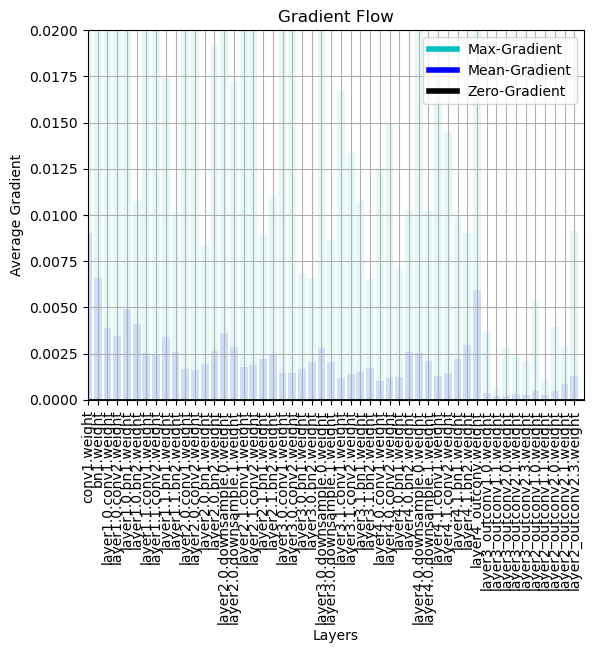

Epoch: 100, Duration: 3.24 sec, Latest Coarse Loss: 3.4441, Latest Fine Loss: 0.4441


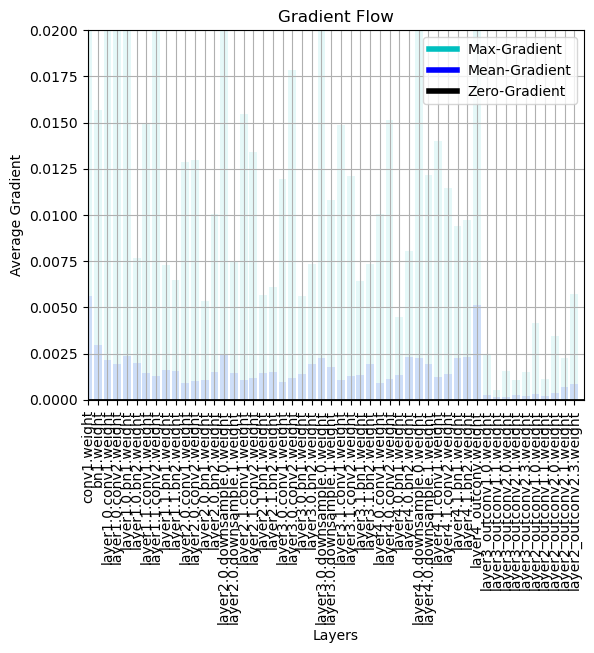

Epoch: 105, Duration: 3.46 sec, Latest Coarse Loss: 3.6504, Latest Fine Loss: 0.4690


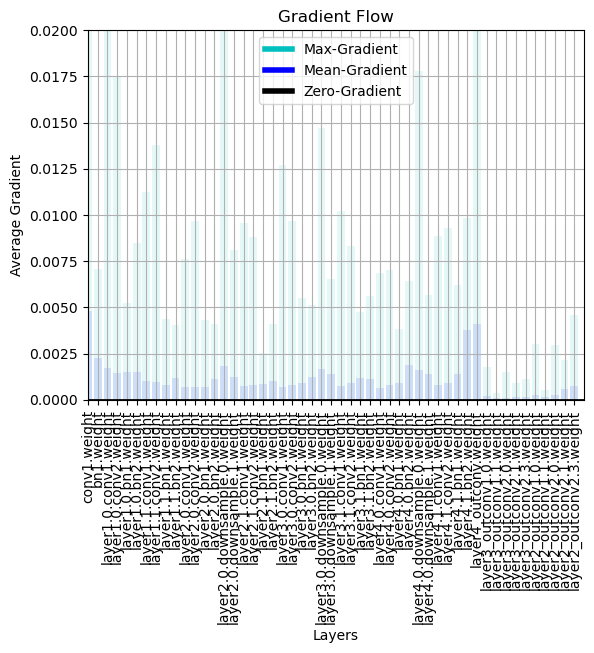

Epoch: 110, Duration: 3.12 sec, Latest Coarse Loss: 2.2505, Latest Fine Loss: 0.4314


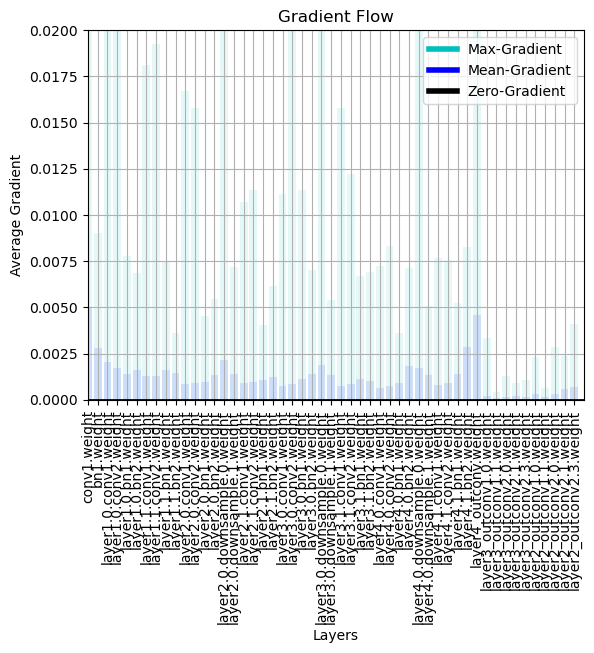

Epoch: 115, Duration: 4.22 sec, Latest Coarse Loss: 2.1143, Latest Fine Loss: 0.4046


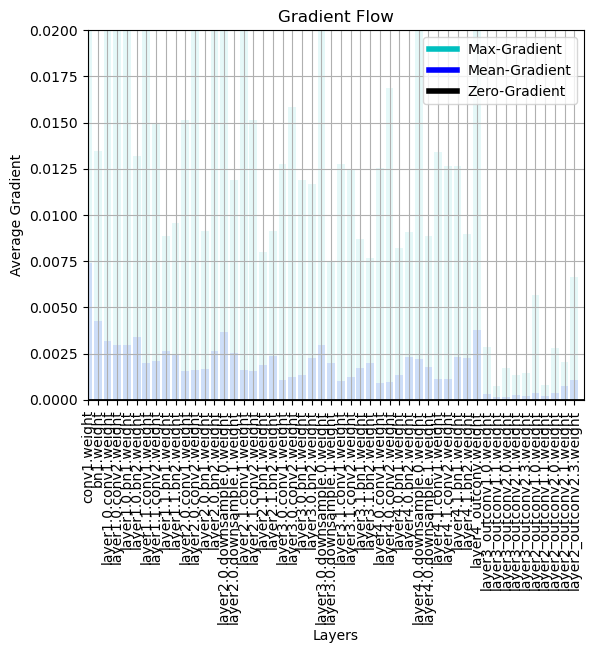

Epoch: 120, Duration: 3.53 sec, Latest Coarse Loss: 2.9037, Latest Fine Loss: 0.4402


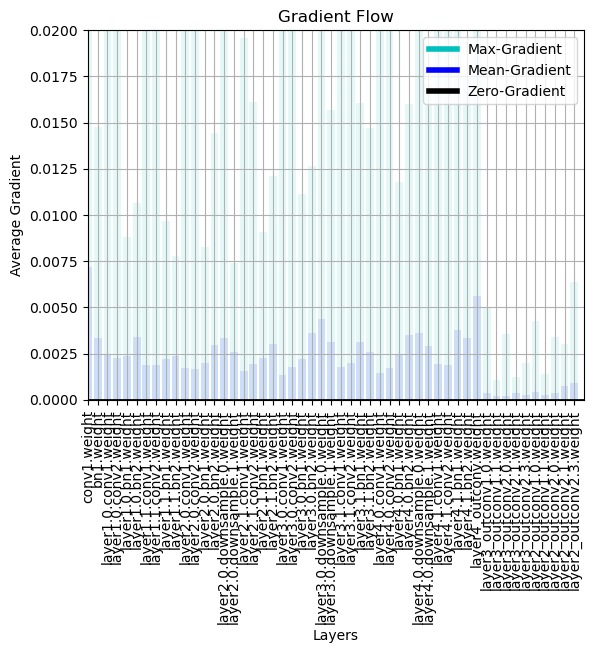

Epoch: 125, Duration: 3.18 sec, Latest Coarse Loss: 3.8995, Latest Fine Loss: 0.5307


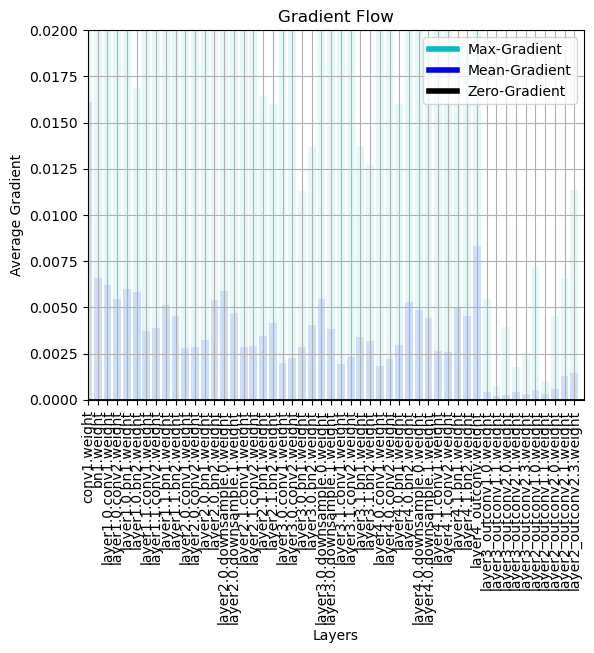

Epoch: 130, Duration: 3.60 sec, Latest Coarse Loss: 4.1170, Latest Fine Loss: 0.5483


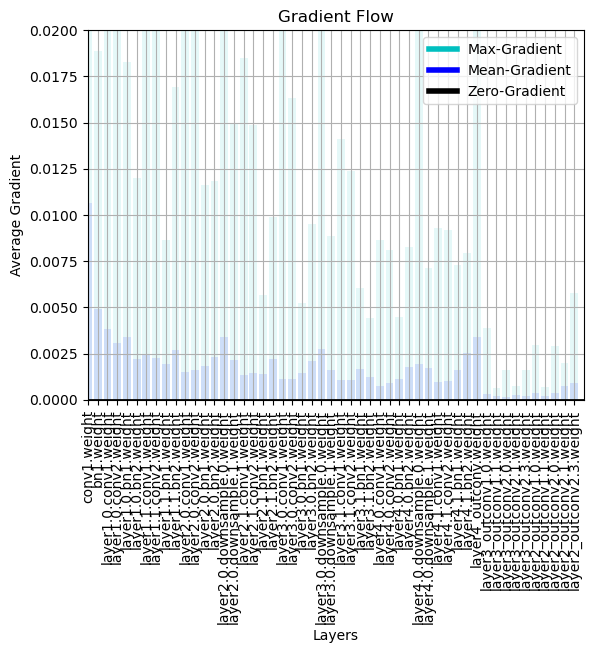

Epoch: 135, Duration: 3.14 sec, Latest Coarse Loss: 2.1718, Latest Fine Loss: 0.4239


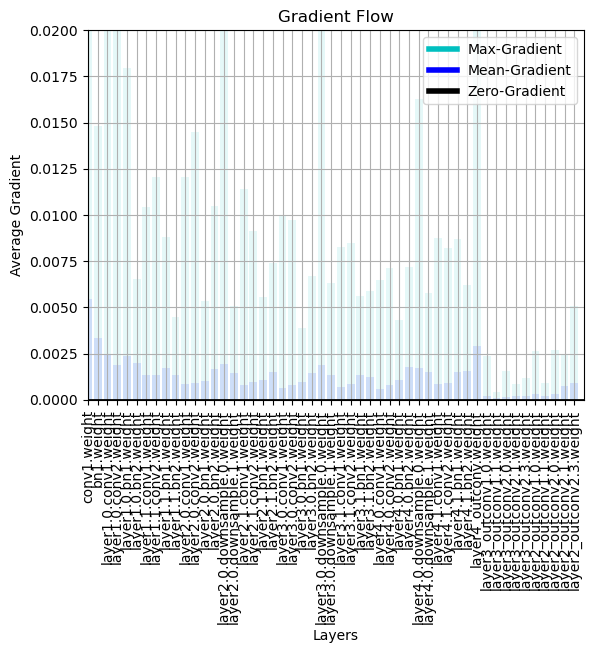

Epoch: 140, Duration: 3.26 sec, Latest Coarse Loss: 2.2944, Latest Fine Loss: 0.3991


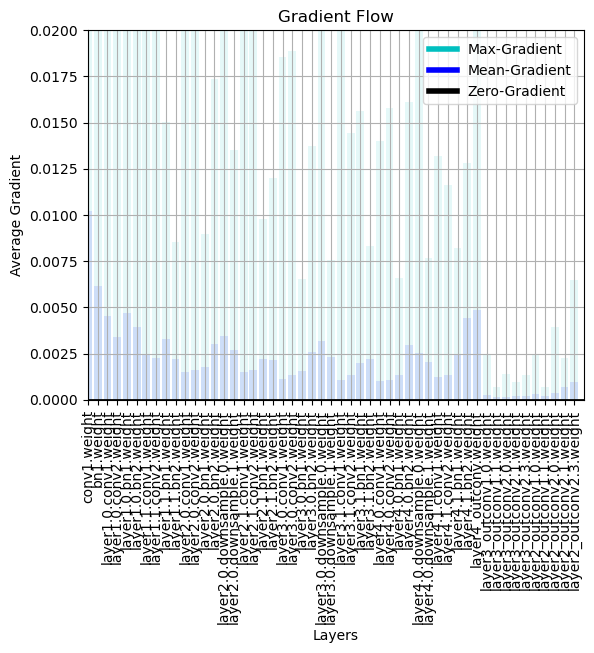

Epoch: 145, Duration: 3.28 sec, Latest Coarse Loss: 2.7776, Latest Fine Loss: 0.3662


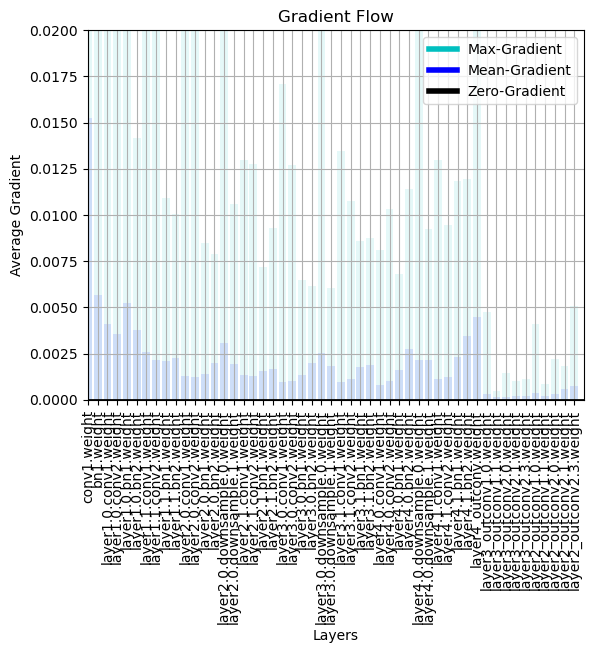

Epoch: 150, Duration: 3.43 sec, Latest Coarse Loss: 3.0788, Latest Fine Loss: 0.4128


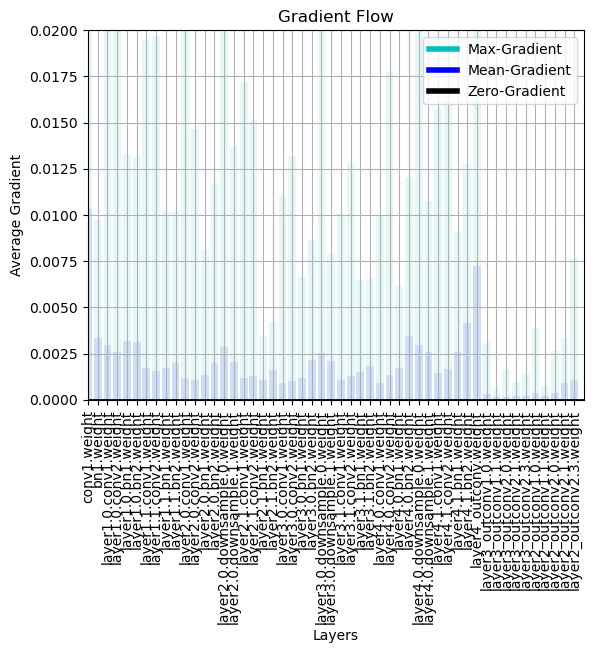

Epoch: 155, Duration: 3.13 sec, Latest Coarse Loss: 3.7690, Latest Fine Loss: 0.4348


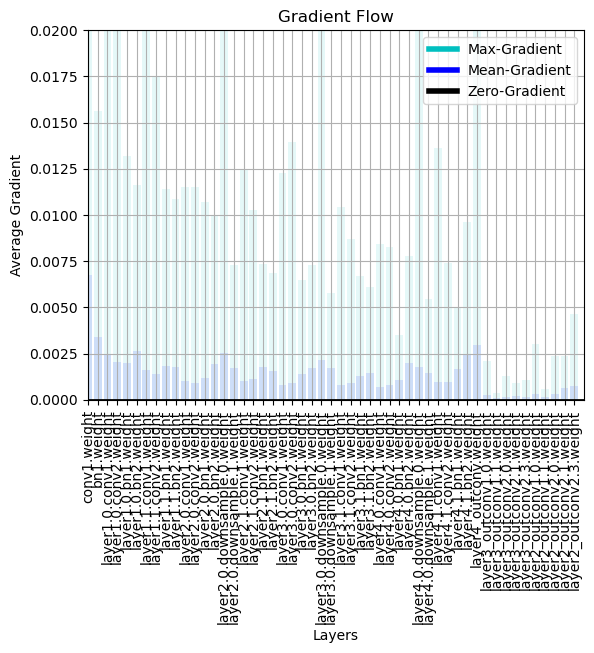

Epoch: 160, Duration: 3.24 sec, Latest Coarse Loss: 2.2610, Latest Fine Loss: 0.3568


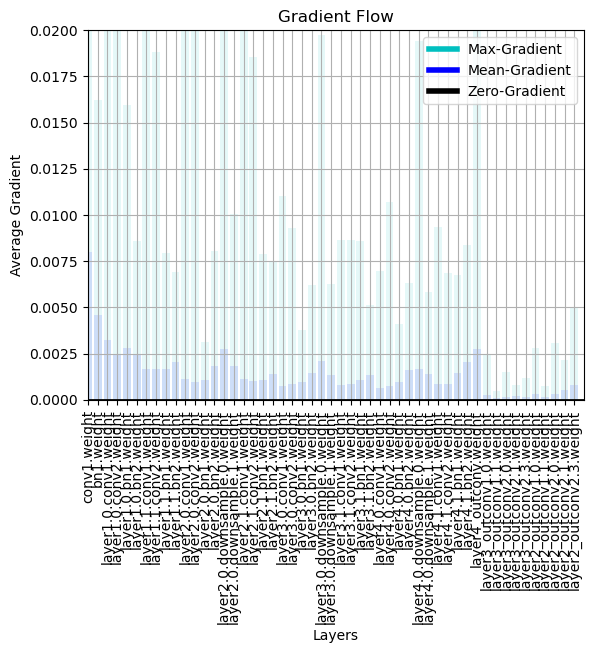

Epoch: 165, Duration: 3.48 sec, Latest Coarse Loss: 2.1271, Latest Fine Loss: 0.3755


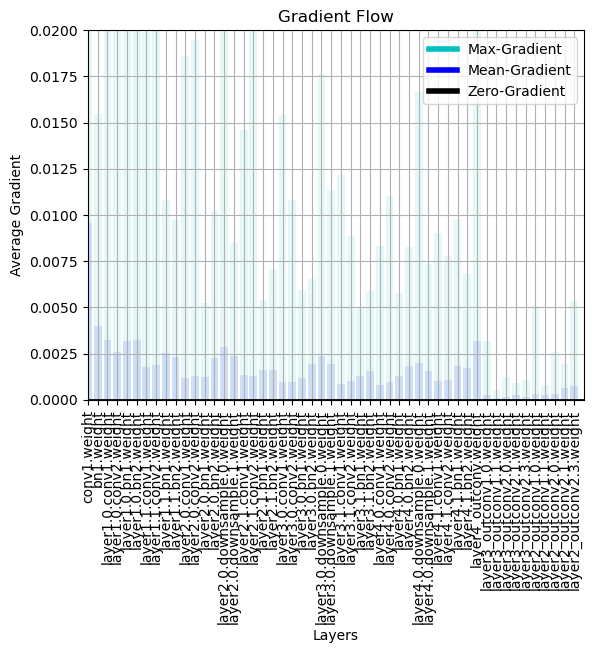

Epoch: 170, Duration: 3.22 sec, Latest Coarse Loss: 1.9523, Latest Fine Loss: 0.3263


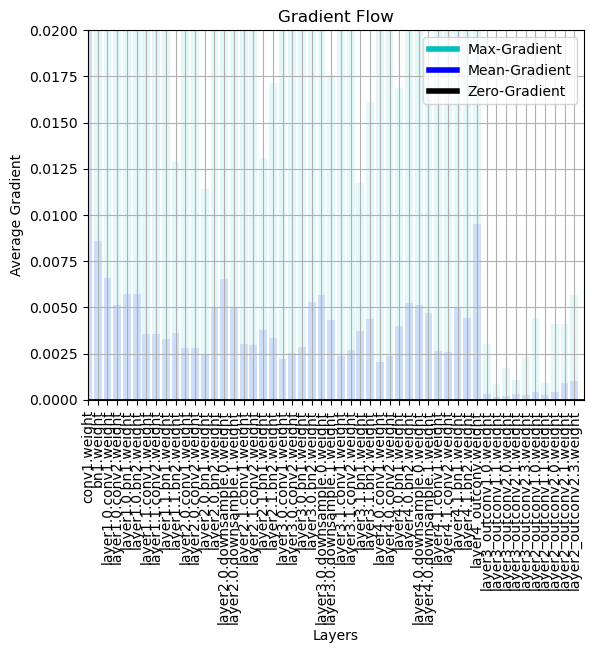

Epoch: 175, Duration: 3.16 sec, Latest Coarse Loss: 4.5022, Latest Fine Loss: 0.4541


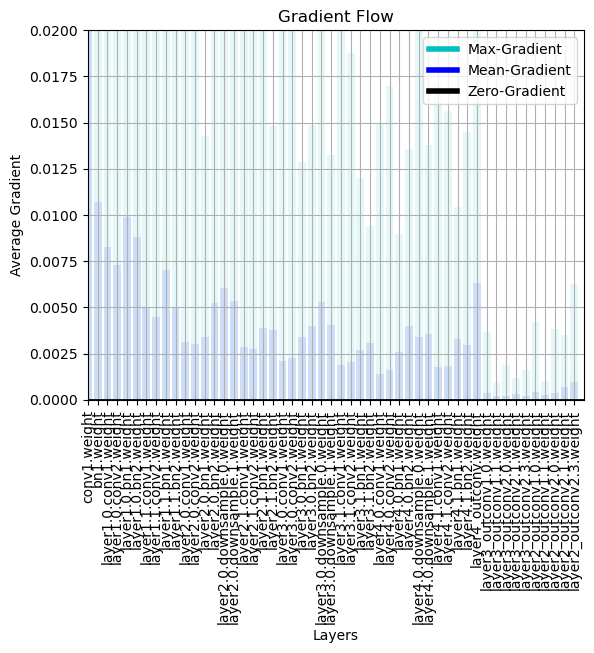

Epoch: 180, Duration: 3.08 sec, Latest Coarse Loss: 3.5058, Latest Fine Loss: 0.3955


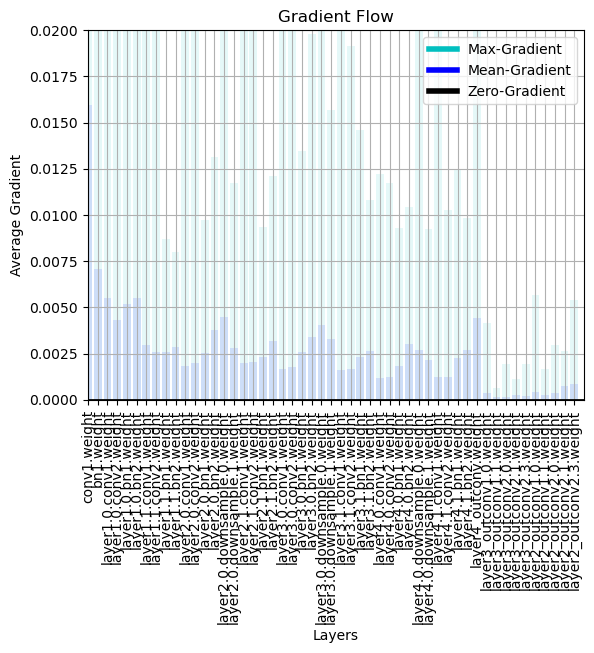

Epoch: 185, Duration: 3.12 sec, Latest Coarse Loss: 3.1488, Latest Fine Loss: 0.4277


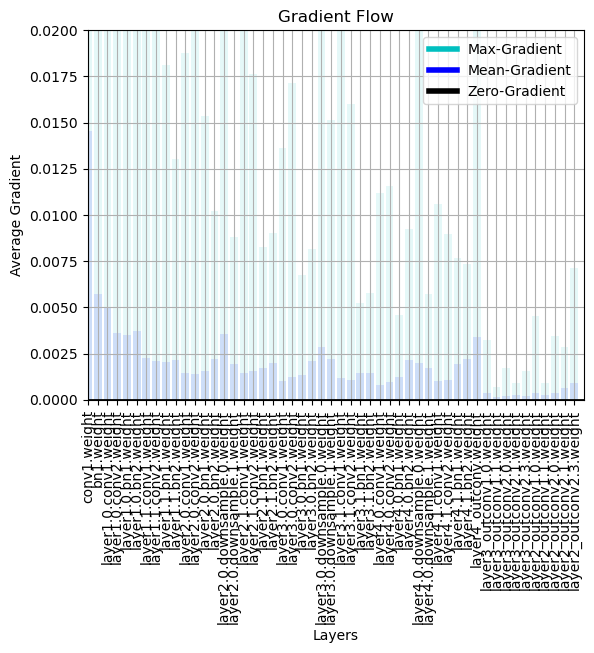

Epoch: 190, Duration: 3.18 sec, Latest Coarse Loss: 3.0308, Latest Fine Loss: 0.4516


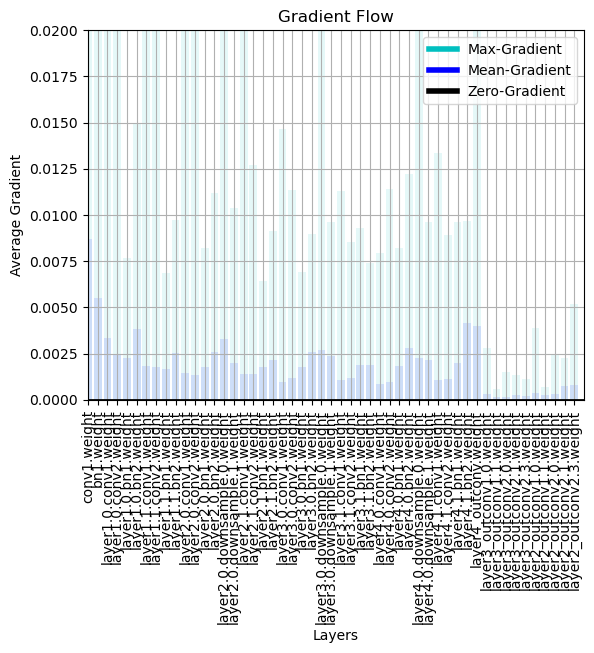

Epoch: 195, Duration: 3.10 sec, Latest Coarse Loss: 2.3565, Latest Fine Loss: 0.3664


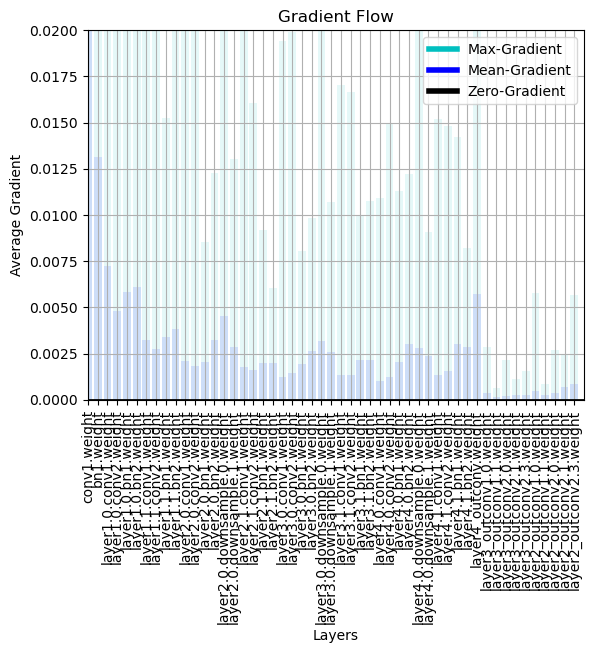

Epoch: 200, Duration: 3.14 sec, Latest Coarse Loss: 3.0581, Latest Fine Loss: 0.4033


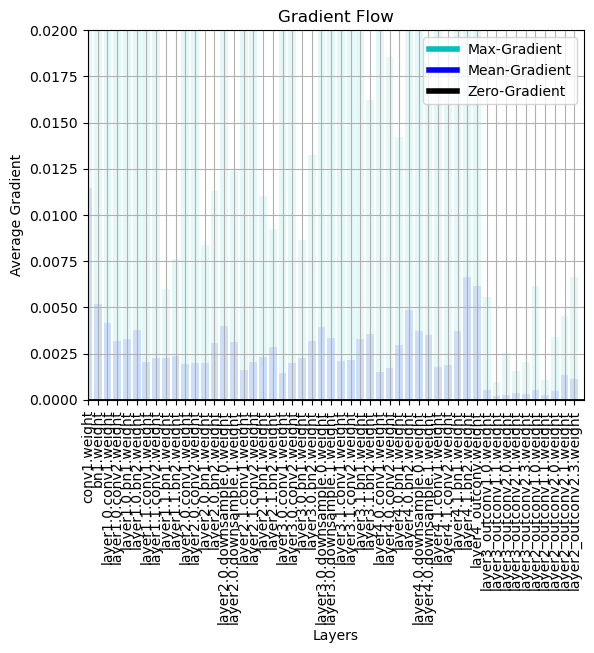

Epoch: 205, Duration: 3.20 sec, Latest Coarse Loss: 3.8712, Latest Fine Loss: 0.6308


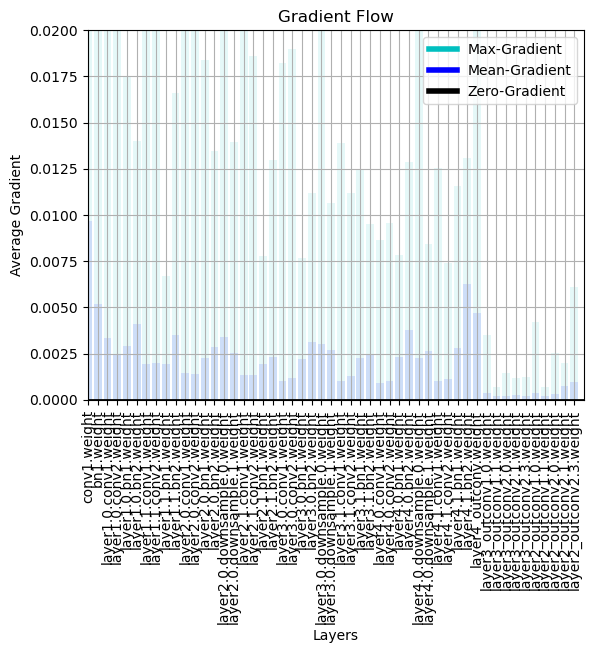

Epoch: 210, Duration: 3.18 sec, Latest Coarse Loss: 2.8374, Latest Fine Loss: 0.4029


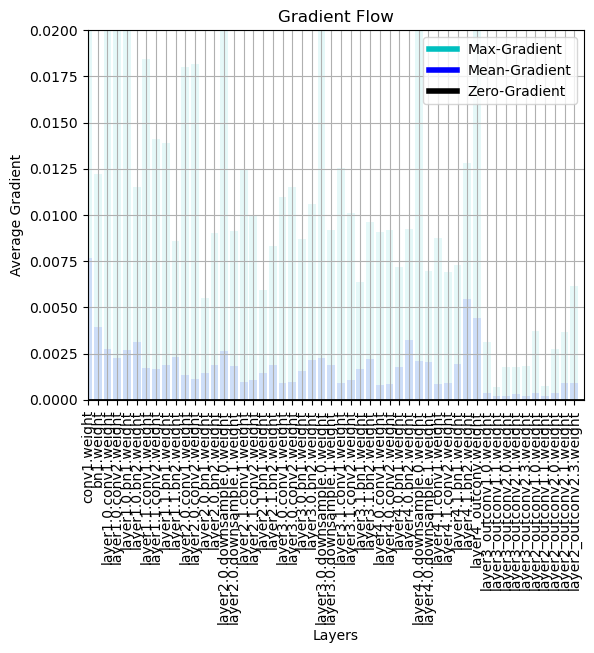

Epoch: 215, Duration: 3.17 sec, Latest Coarse Loss: 3.6169, Latest Fine Loss: 0.3917


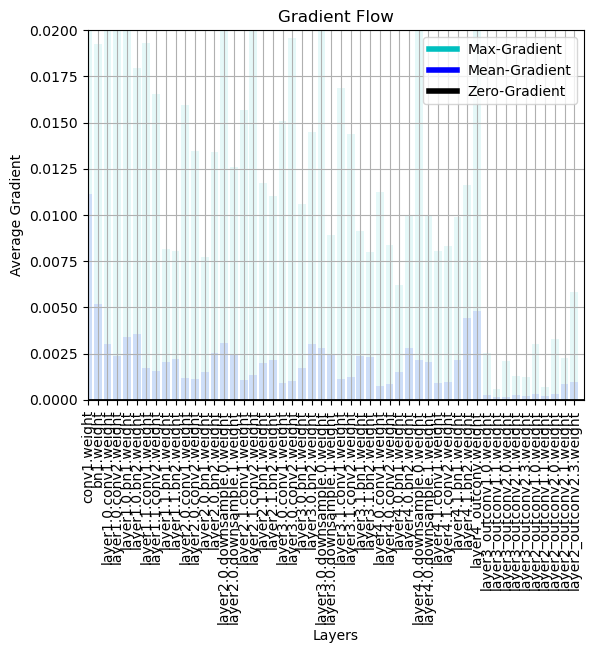

Epoch: 220, Duration: 3.15 sec, Latest Coarse Loss: 3.0673, Latest Fine Loss: 0.3596


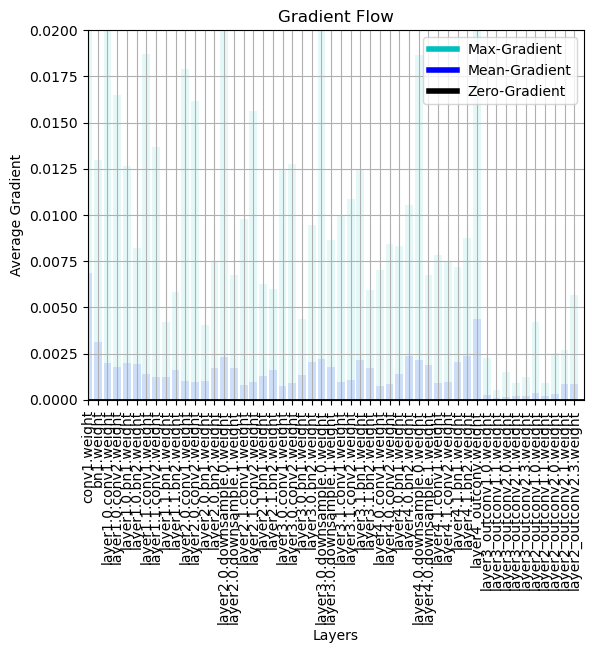

Epoch: 225, Duration: 3.15 sec, Latest Coarse Loss: 3.0232, Latest Fine Loss: 0.3761


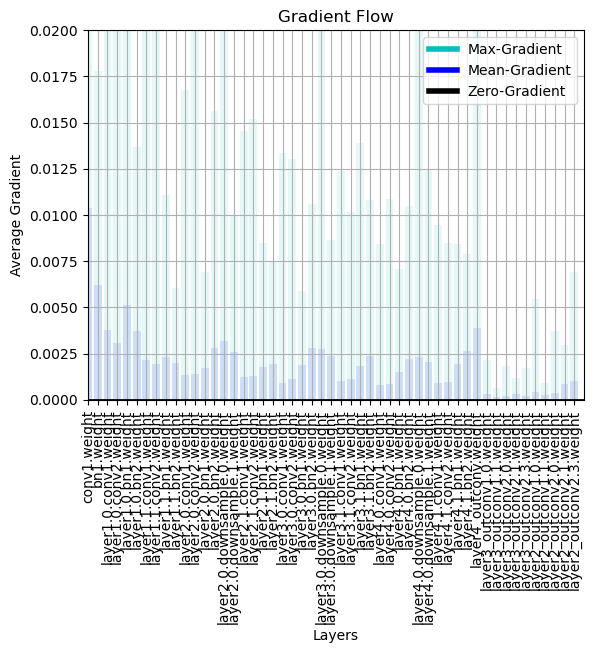

Epoch: 230, Duration: 3.10 sec, Latest Coarse Loss: 2.3774, Latest Fine Loss: 0.4286


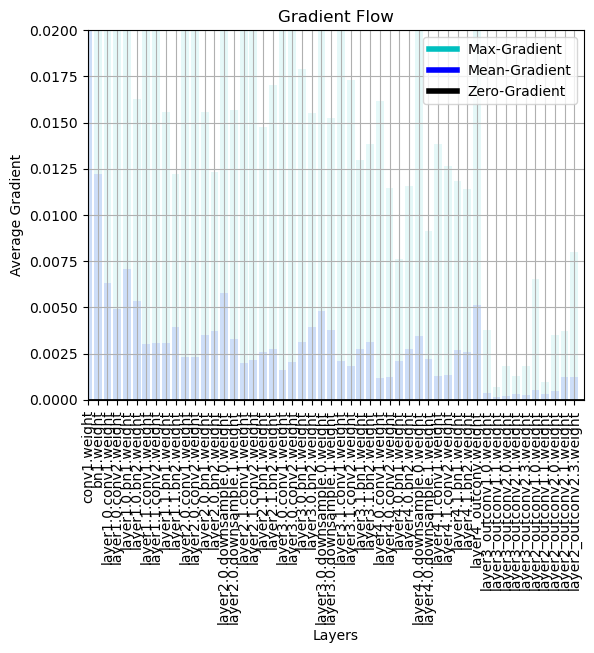

Epoch: 235, Duration: 3.54 sec, Latest Coarse Loss: 3.4634, Latest Fine Loss: 0.5081


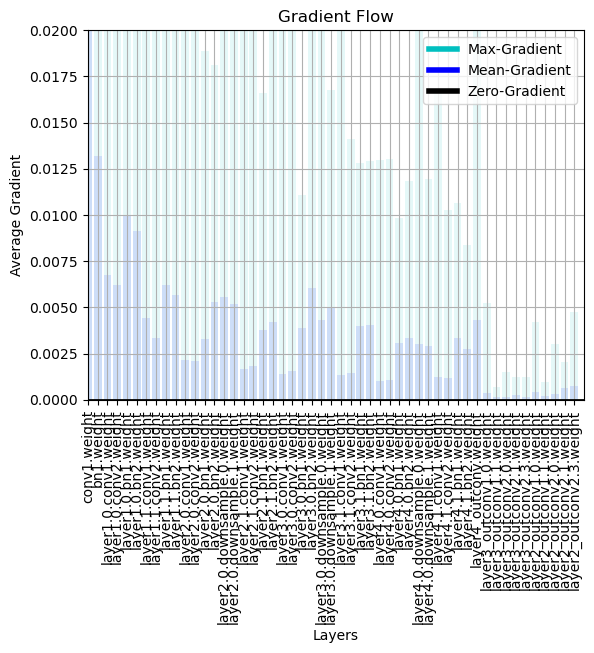

Epoch: 240, Duration: 4.22 sec, Latest Coarse Loss: 3.4064, Latest Fine Loss: 0.4395


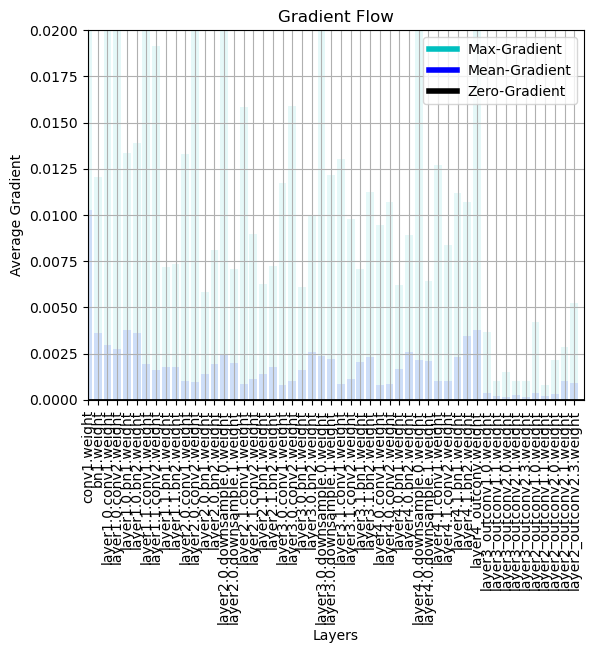

Epoch: 245, Duration: 3.22 sec, Latest Coarse Loss: 2.9554, Latest Fine Loss: 0.3617


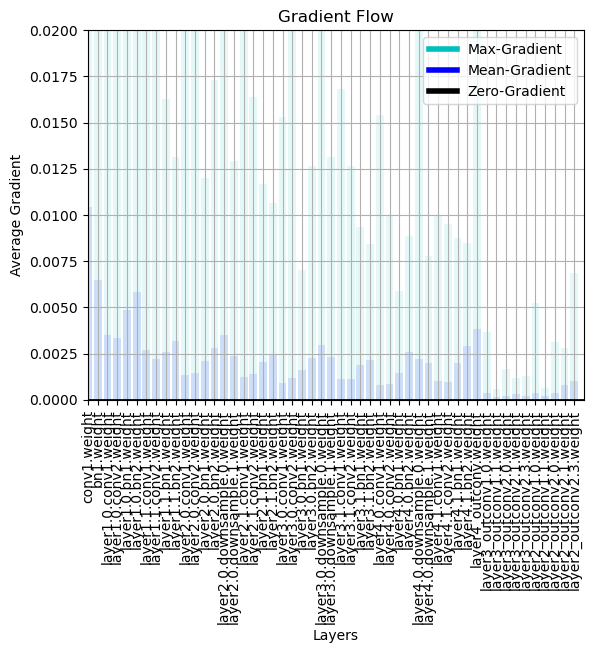

Epoch: 250, Duration: 3.08 sec, Latest Coarse Loss: 2.8150, Latest Fine Loss: 0.4307


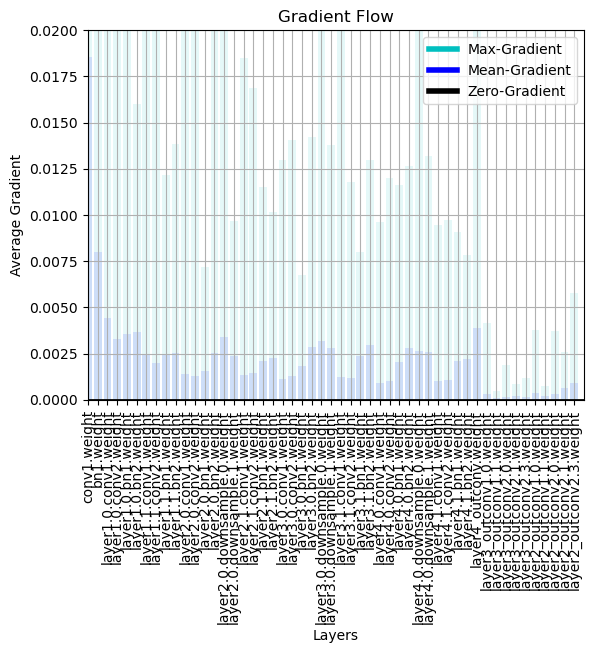

Epoch: 255, Duration: 3.02 sec, Latest Coarse Loss: 2.9146, Latest Fine Loss: 0.4566


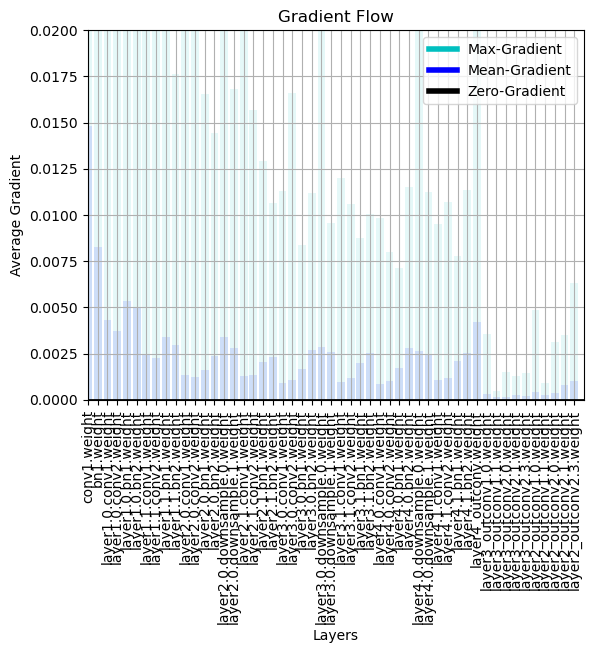

Epoch: 260, Duration: 2.87 sec, Latest Coarse Loss: 2.2234, Latest Fine Loss: 0.4022


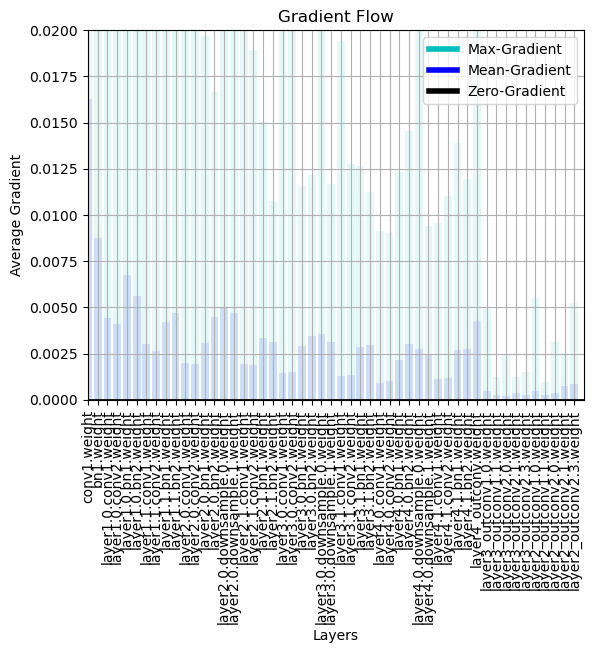

Epoch: 265, Duration: 2.99 sec, Latest Coarse Loss: 2.7794, Latest Fine Loss: 0.3911


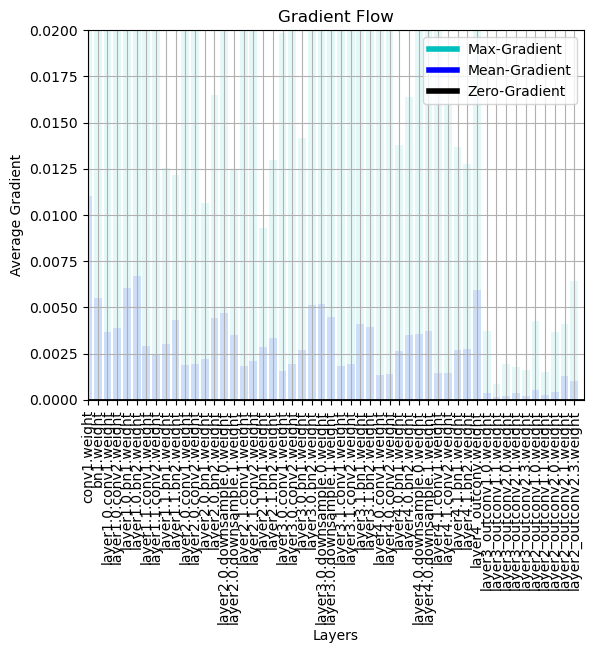

Epoch: 270, Duration: 2.96 sec, Latest Coarse Loss: 3.1065, Latest Fine Loss: 0.4523


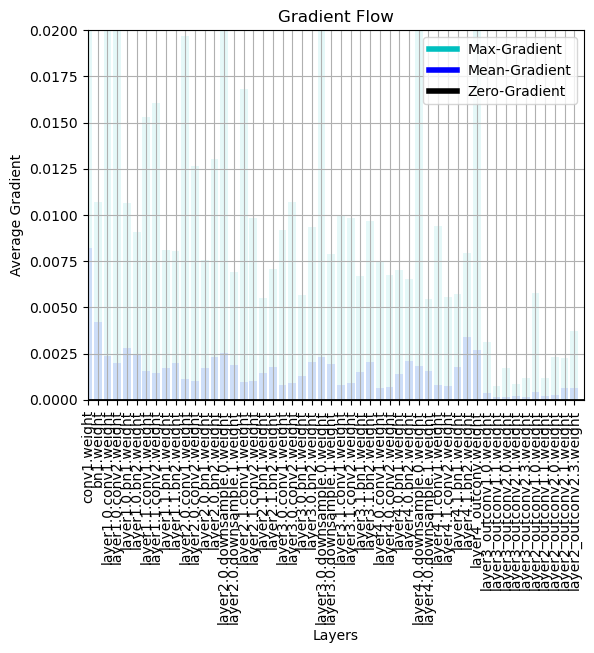

Epoch: 275, Duration: 3.06 sec, Latest Coarse Loss: 2.0826, Latest Fine Loss: 0.3469


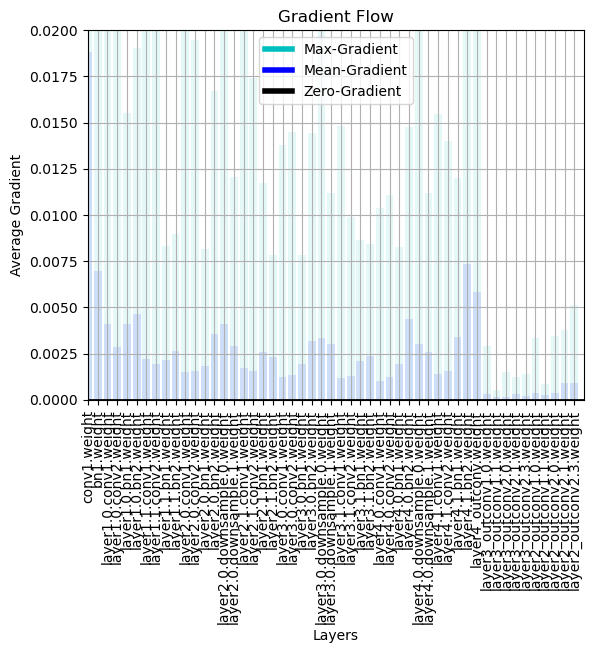

Epoch: 280, Duration: 2.98 sec, Latest Coarse Loss: 3.5814, Latest Fine Loss: 0.4254


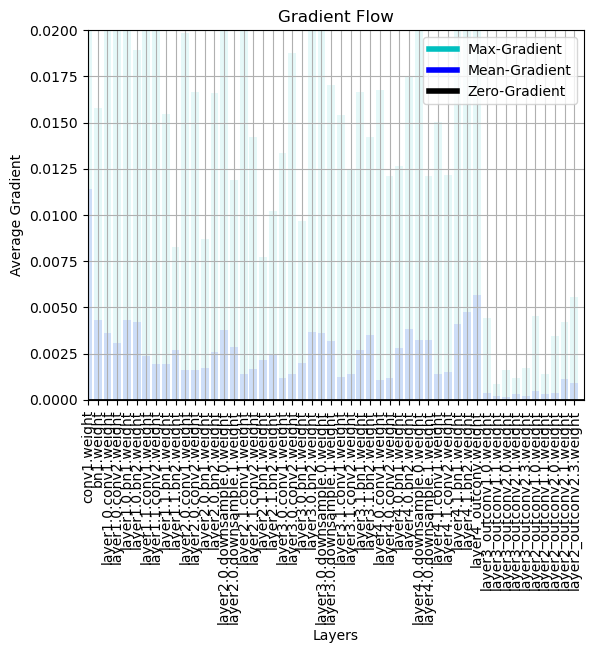

Epoch: 285, Duration: 2.95 sec, Latest Coarse Loss: 3.5133, Latest Fine Loss: 0.4719


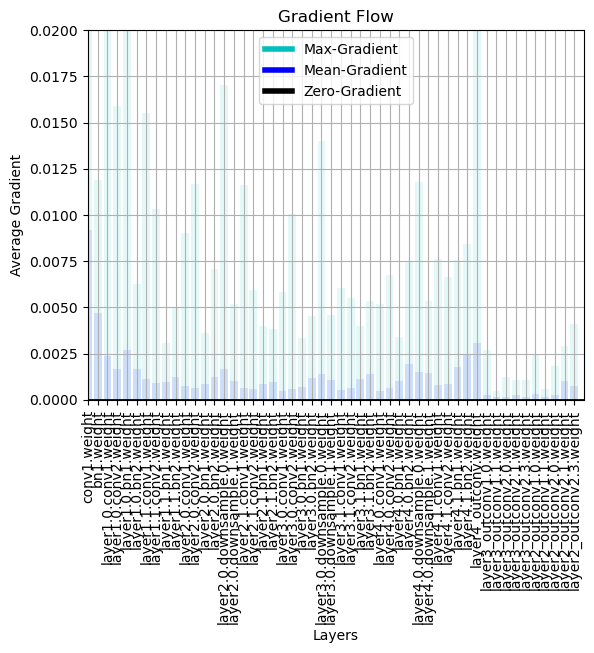

Epoch: 290, Duration: 3.58 sec, Latest Coarse Loss: 1.9283, Latest Fine Loss: 0.3300


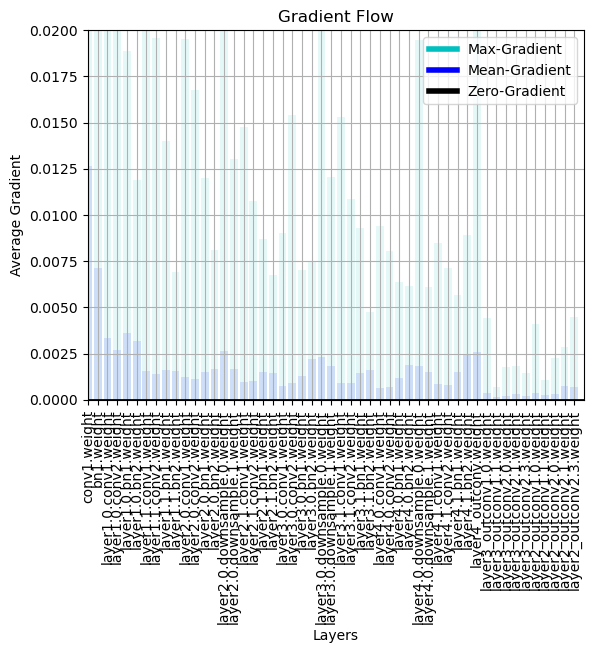

Epoch: 295, Duration: 3.47 sec, Latest Coarse Loss: 2.3729, Latest Fine Loss: 0.4377


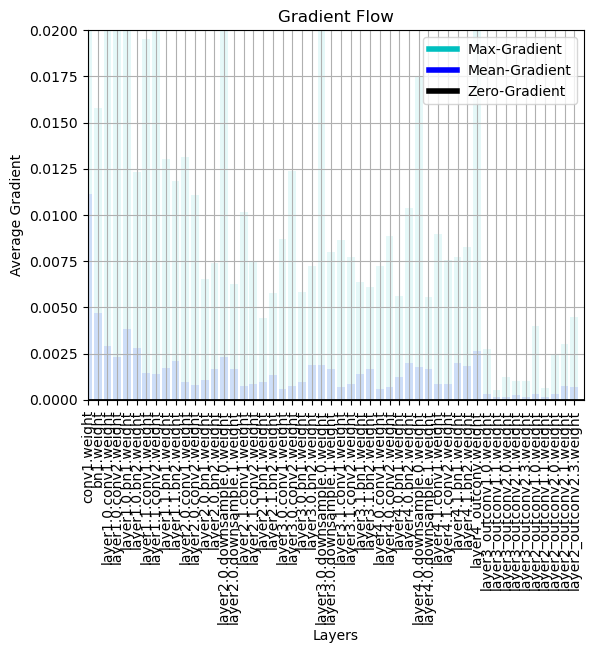

Epoch: 300, Duration: 3.27 sec, Latest Coarse Loss: 2.0870, Latest Fine Loss: 0.3453


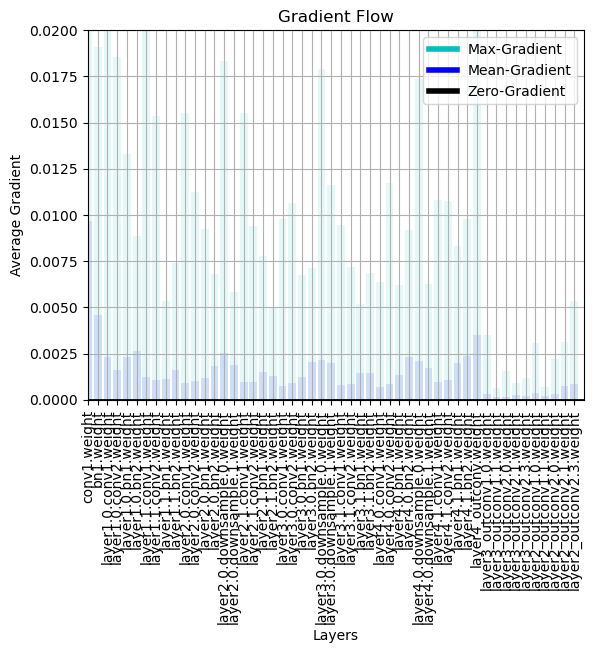

Epoch: 305, Duration: 3.16 sec, Latest Coarse Loss: 1.9725, Latest Fine Loss: 0.3401


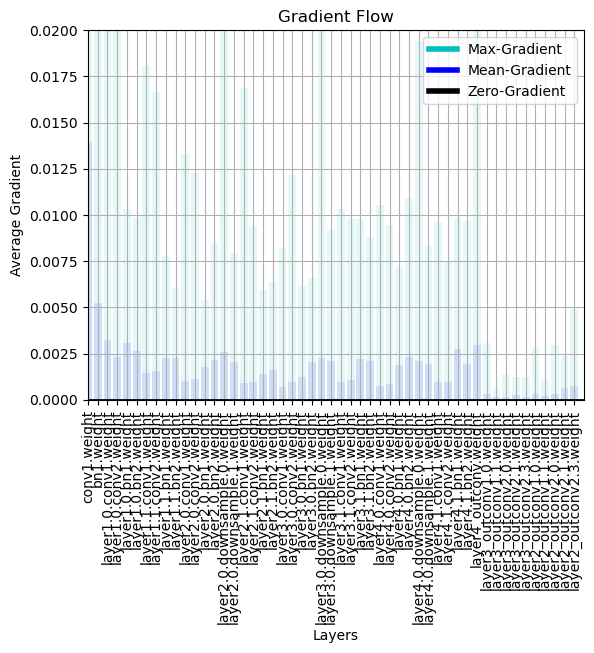

Epoch: 310, Duration: 3.06 sec, Latest Coarse Loss: 1.8050, Latest Fine Loss: 0.3323


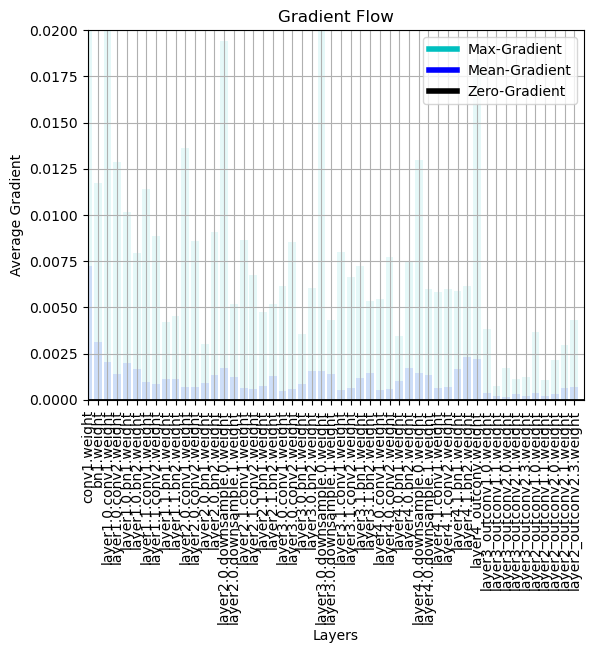

Epoch: 315, Duration: 3.17 sec, Latest Coarse Loss: 1.4482, Latest Fine Loss: 0.3241


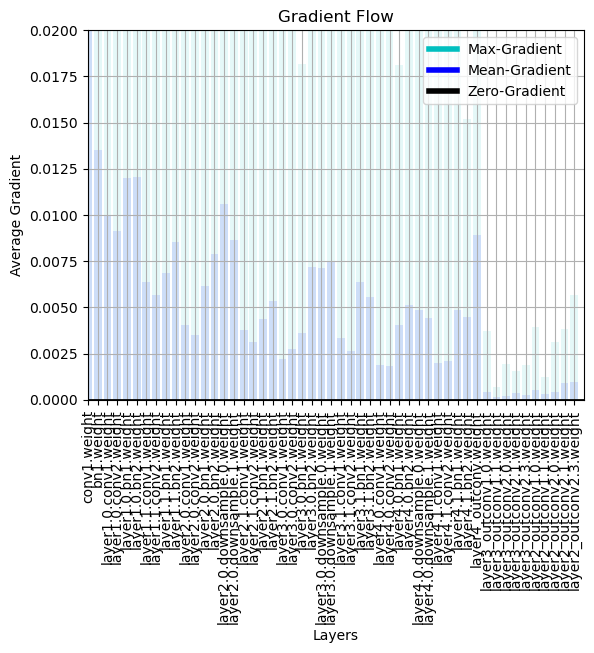

Epoch: 320, Duration: 3.19 sec, Latest Coarse Loss: 2.9930, Latest Fine Loss: 0.4228


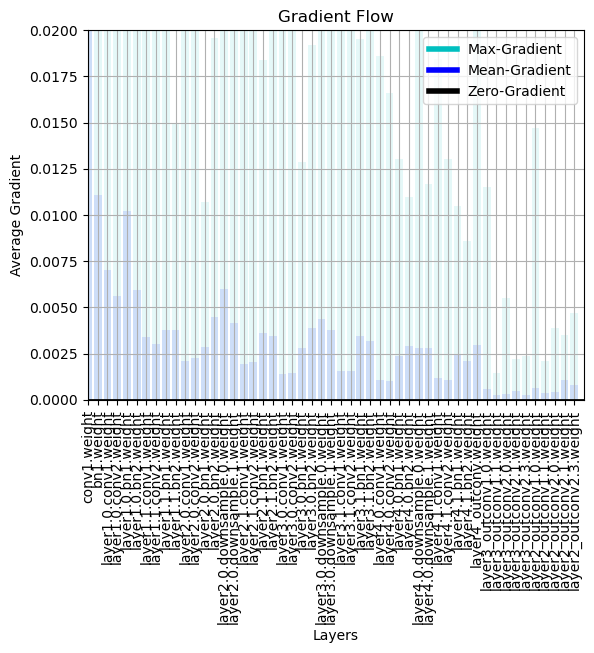

Epoch: 325, Duration: 3.14 sec, Latest Coarse Loss: 2.8954, Latest Fine Loss: 0.4935


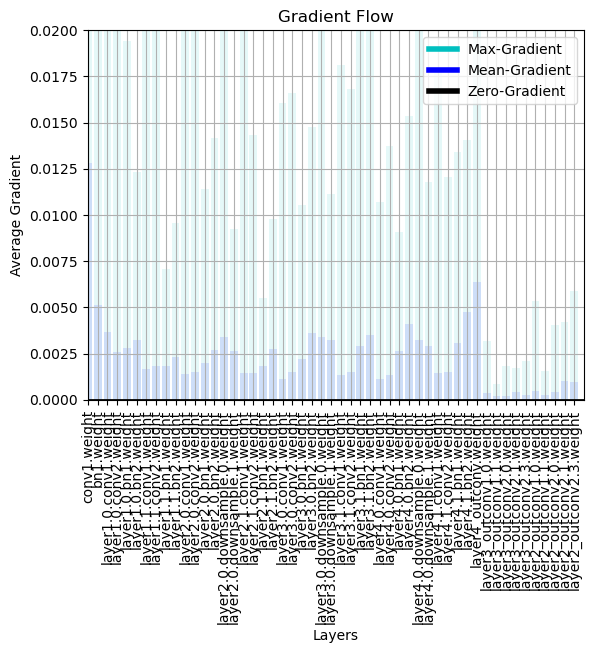

Epoch: 330, Duration: 3.11 sec, Latest Coarse Loss: 3.0292, Latest Fine Loss: 0.4214


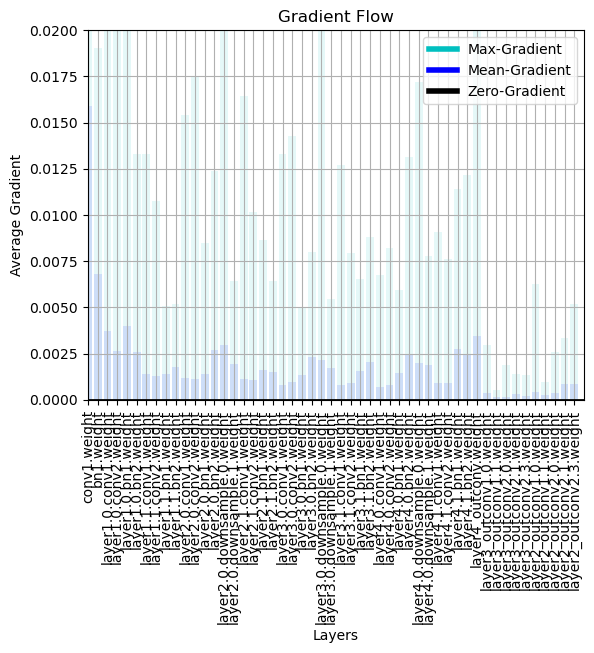

Epoch: 335, Duration: 3.11 sec, Latest Coarse Loss: 2.8458, Latest Fine Loss: 0.4602


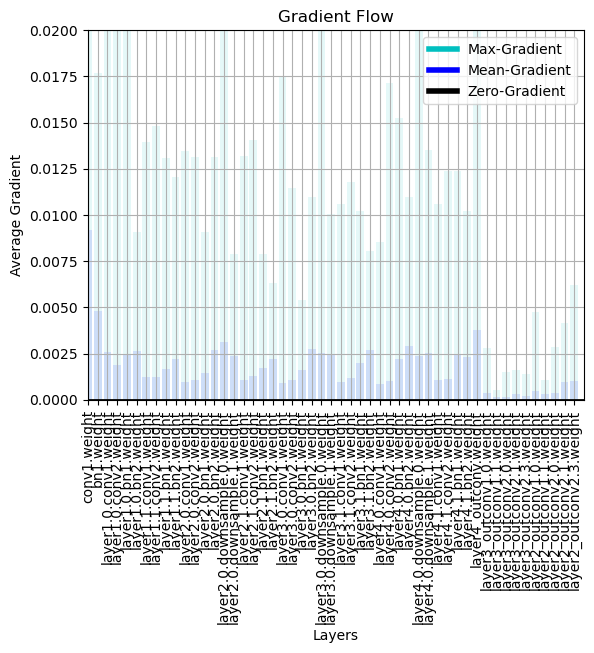

Epoch: 340, Duration: 3.11 sec, Latest Coarse Loss: 2.3087, Latest Fine Loss: 0.3734


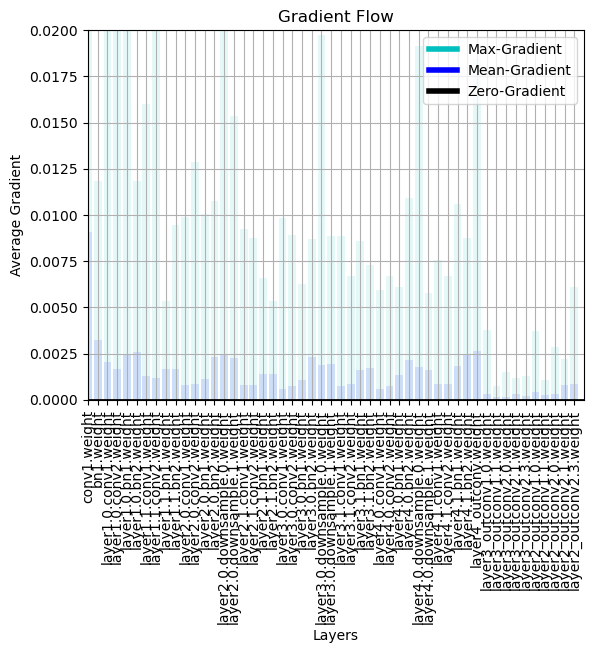

Epoch: 345, Duration: 3.20 sec, Latest Coarse Loss: 1.6944, Latest Fine Loss: 0.3438


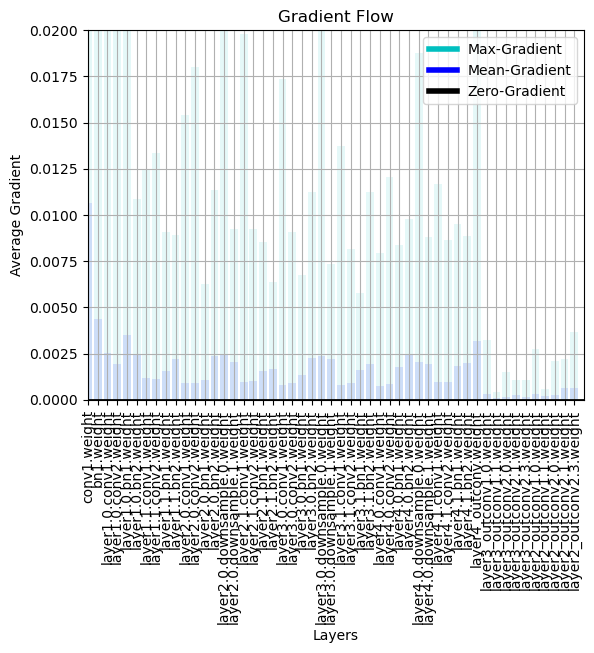

Epoch: 350, Duration: 3.13 sec, Latest Coarse Loss: 2.1211, Latest Fine Loss: 0.3140


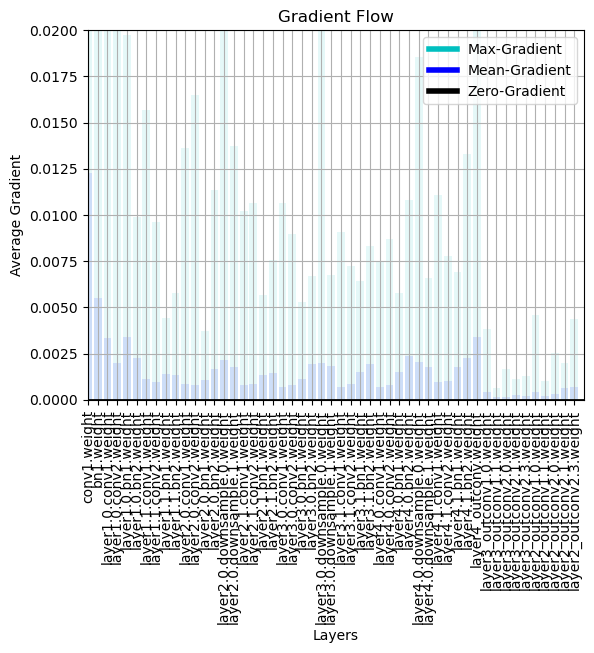

Epoch: 355, Duration: 3.15 sec, Latest Coarse Loss: 2.4248, Latest Fine Loss: 0.3346


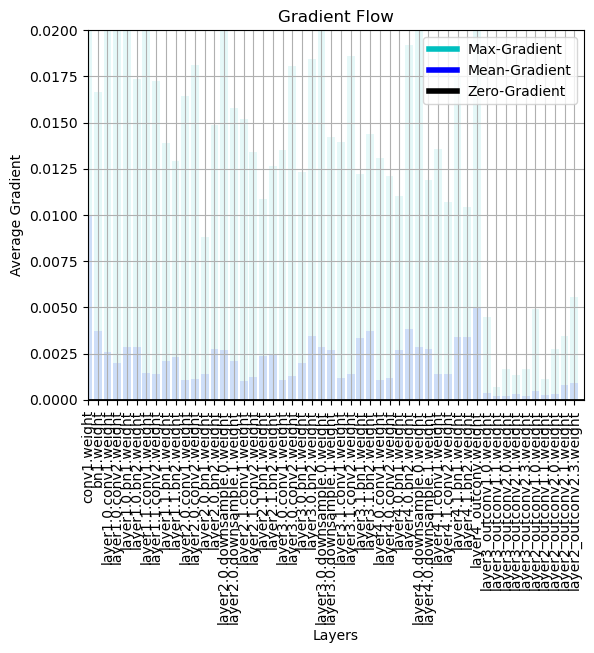

Epoch: 360, Duration: 3.11 sec, Latest Coarse Loss: 2.8163, Latest Fine Loss: 0.3658


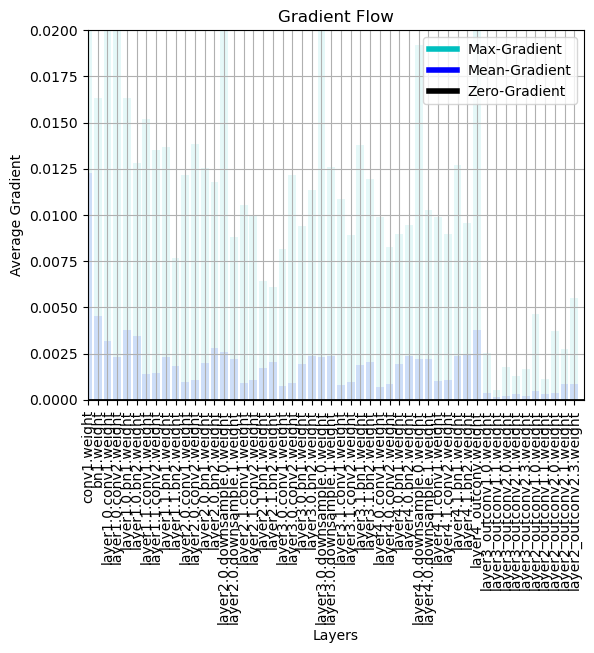

Epoch: 365, Duration: 3.17 sec, Latest Coarse Loss: 2.4592, Latest Fine Loss: 0.3591


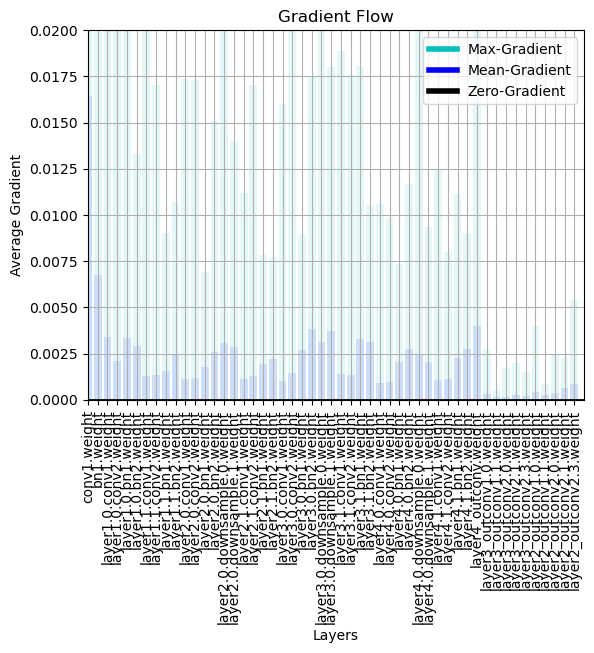

Epoch: 370, Duration: 3.19 sec, Latest Coarse Loss: 2.4295, Latest Fine Loss: 0.3173


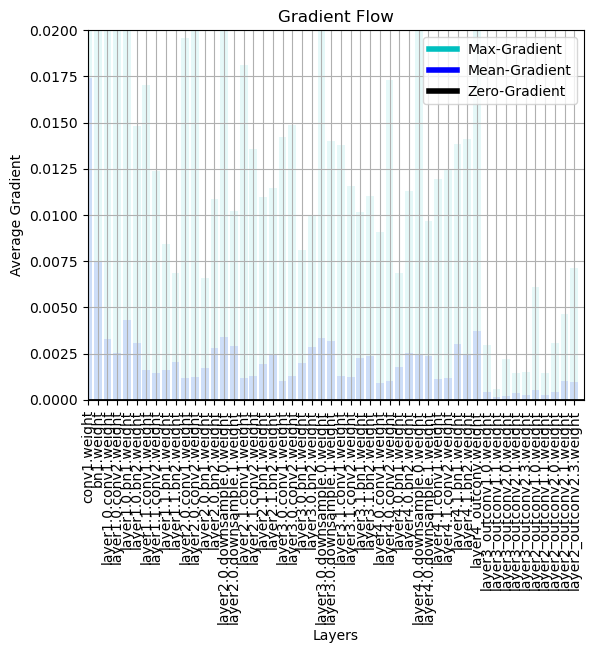

Epoch: 375, Duration: 3.21 sec, Latest Coarse Loss: 2.6191, Latest Fine Loss: 0.4350


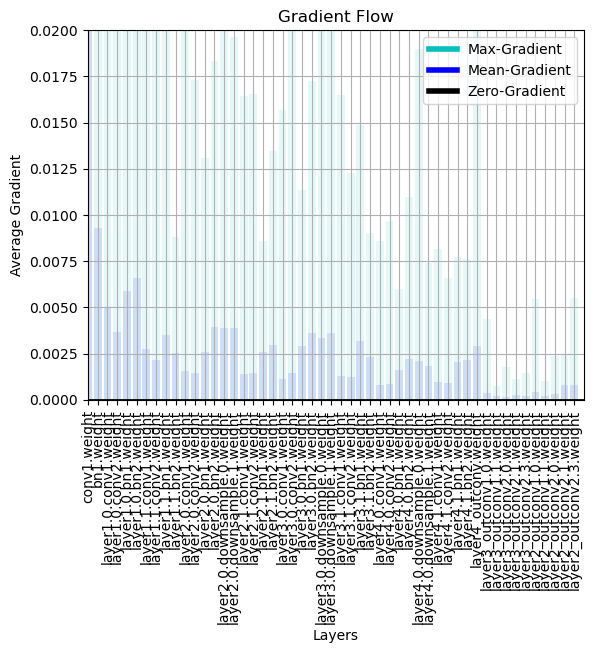

Epoch: 380, Duration: 3.28 sec, Latest Coarse Loss: 1.8080, Latest Fine Loss: 0.3367


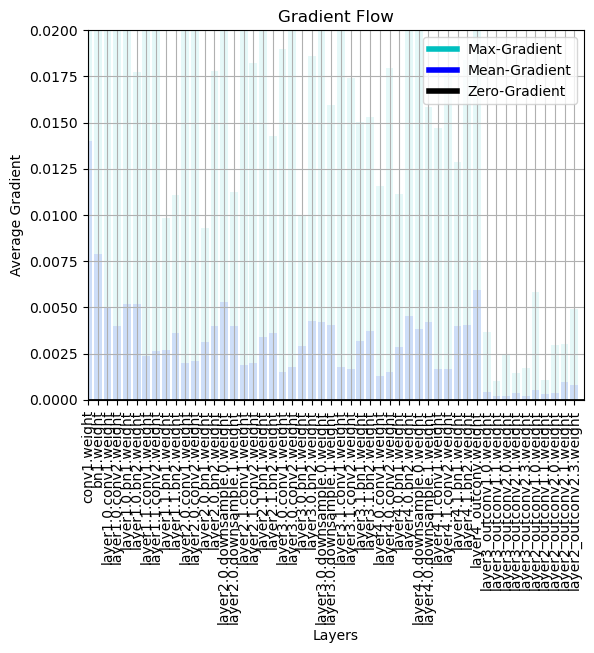

Epoch: 385, Duration: 3.68 sec, Latest Coarse Loss: 3.6891, Latest Fine Loss: 0.4826


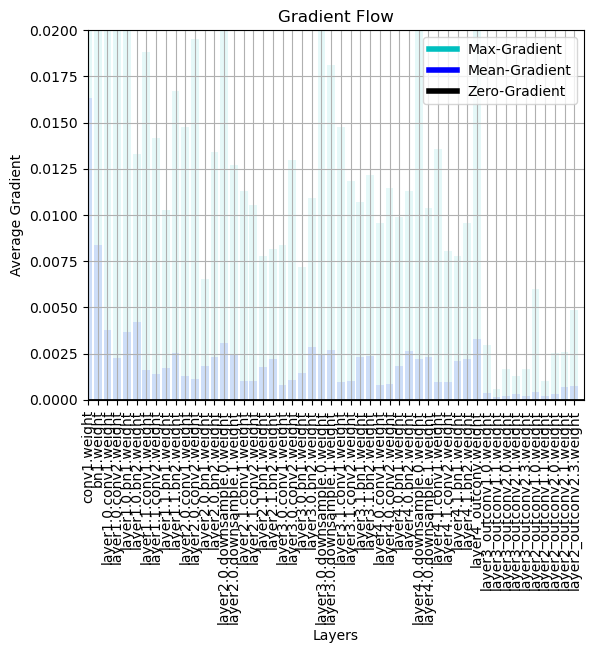

Epoch: 390, Duration: 3.16 sec, Latest Coarse Loss: 2.2293, Latest Fine Loss: 0.3558


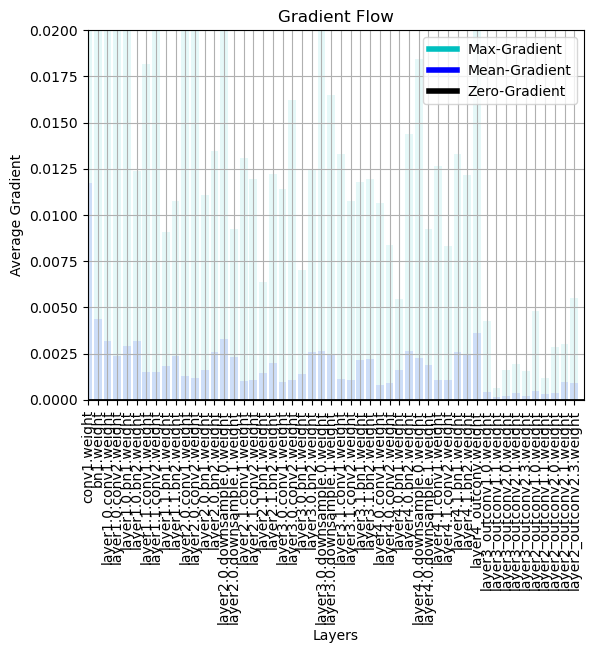

Epoch: 395, Duration: 3.49 sec, Latest Coarse Loss: 2.4911, Latest Fine Loss: 0.3988


In [10]:
print_frequency = 5
epochs = 400

for epoch in range(epochs):
    epoch_start_time = time.time()
    for (
        image_1_crop,
        image_2_crop,
        match_matrix,
        relative_coordinates,
        _,
    ) in dataloader_train:
        seen_datapoints += image_1_crop.shape[0]
        image_1_crop = image_1_crop.to(device=device)
        image_2_crop = image_2_crop.to(device=device)
        match_matrix = match_matrix.to(device=device)
        relative_coordinates = relative_coordinates.to(device=device)

        optimizer.zero_grad()

        coarse_image_feature_1, fine_image_feature_1 = backbone(image_1_crop)
        coarse_image_feature_2, fine_image_feature_2 = backbone(image_2_crop)
        
        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after backbone. Breaking the training.")
            break

        coarse_image_feature_1 = positional_encoding(coarse_image_feature_1)
        coarse_image_feature_2 = positional_encoding(coarse_image_feature_2)

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after positional_encoding. Breaking the training.")
            break

        coarse_image_feature_1 = rearrange(
            coarse_image_feature_1, "n c h w -> n (h w) c"
        )
        coarse_image_feature_2 = rearrange(
            coarse_image_feature_2, "n c h w -> n (h w) c"
        )

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after rearrange. Breaking the training.")
            break

        coarse_image_feature_1, coarse_image_feature_2 = coarse_loftr(
            coarse_image_feature_1, coarse_image_feature_2
        )

        if coarse_image_feature_1.isnan().any().item():
            print("coarse_image_feature_1 contains NaN values after coarse_loftr. Breaking the training.")
            break

        coarse_matches = coarse_matcher(coarse_image_feature_1, coarse_image_feature_2)

        if coarse_matches["confidence_matrix"].isnan().any().item():
            print("coarse_matches['confidence_matrix'] contains NaN values. Breaking the training.")
            break

        coarse_matches_ground_truth = {
            "batch_indices": match_matrix.nonzero()[:, 0],
            "row_indices": match_matrix.nonzero()[:, 1],
            "column_indices": match_matrix.nonzero()[:, 2],
        }

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_preprocess(
            coarse_image_feature_1=coarse_image_feature_1,
            coarse_image_feature_2=coarse_image_feature_2,
            fine_image_feature_1=fine_image_feature_1,
            fine_image_feature_2=fine_image_feature_2,
            coarse_matches=coarse_matches_ground_truth,
            fine_height=160,
            coarse_height=40,
        )

        fine_image_feature_1_unfold, fine_image_feature_2_unfold = fine_loftr(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        predicted_relative_coordinates = fine_matching(
            fine_image_feature_1_unfold, fine_image_feature_2_unfold
        )

        if coarse_loss == "focal":
            coarse_loss_value = coarse_focal_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
                alpha=alpha,
                gamma=gamma,
            )

        elif coarse_loss == "cross_entropy":
            coarse_loss_value = coarse_cross_entropy_loss(
                predicted_confidence=coarse_matches["confidence_matrix"],
                ground_truth_confidence=match_matrix,
            )

        if fine_loss == "l2":
            fine_loss_value = fine_l2_loss(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        elif fine_loss == "l2_std":
            fine_loss_value = fine_l2_loss_with_standard_deviation(
                coordinates_predicted=predicted_relative_coordinates,
                coordinates_ground_truth=relative_coordinates,
            )

        loss = coarse_loss_value + fine_loss_value
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        coarse_loss_history.append(coarse_loss_value.cpu().item())
        fine_loss_history.append(fine_loss_value.cpu().item())

        if torch.isnan(coarse_matches["confidence_matrix"]).all():
            print(
                "coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training."
            )
            break
    if torch.isnan(coarse_matches["confidence_matrix"]).all():
        print(
            "coarse_matches['confidence_matrix'] is filled with NaN values. Breaking the training."
        )
        break

    epoch_duration = time.time() - epoch_start_time
    if epoch % print_frequency == 0 or epoch == (100 - 1):
        plot_grad_flow_hist(backbone.named_parameters())
        print(
            f"Epoch: {epoch}, Duration: {epoch_duration:.2f} sec, Latest Coarse Loss: {coarse_loss_value:.4f}, Latest Fine Loss: {fine_loss_value:.4f}"
        )

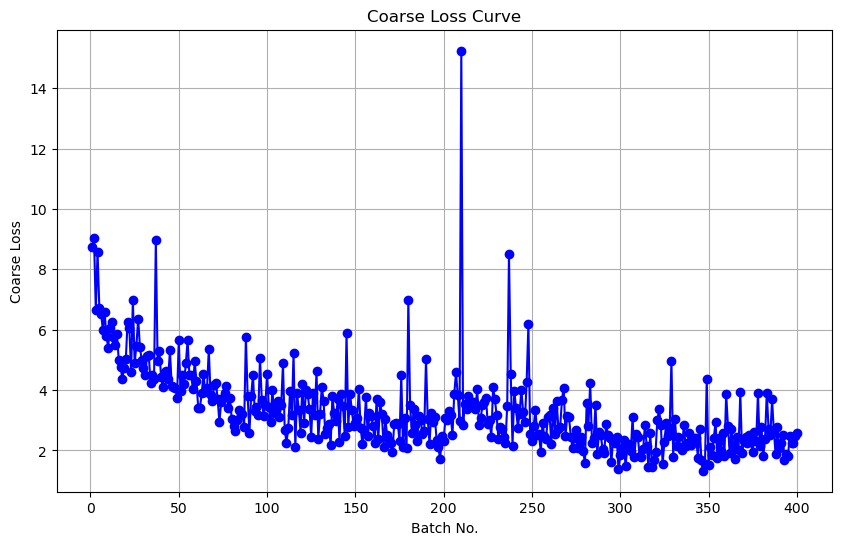

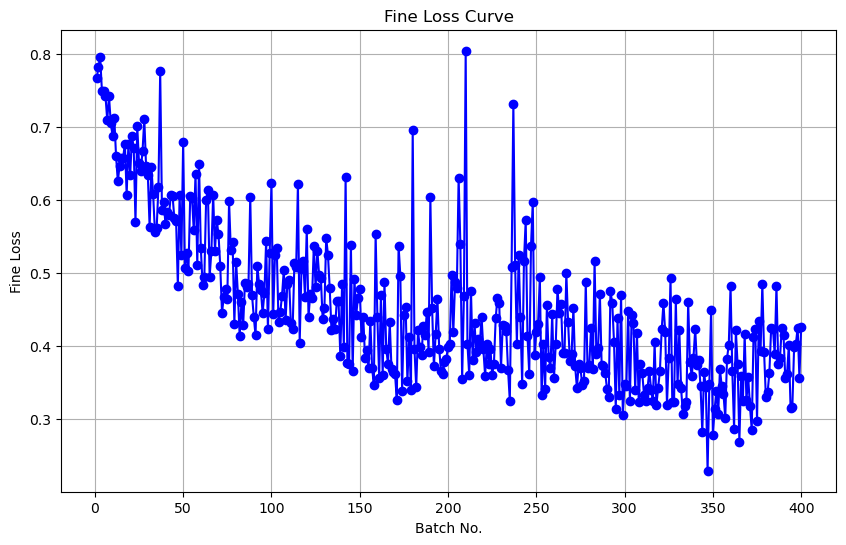

In [14]:
plot_loss_curve(coarse_loss_history, title="Coarse Loss Curve", ylabel="Coarse Loss")
plot_loss_curve(fine_loss_history, title="Fine Loss Curve", ylabel="Fine Loss")

In [15]:
from source.miscellaneous.model_saving import save_model

In [16]:
hyperparameters = {
    "learning_rate": learning_rate,
    "weight_decay": weight_decay,
    "coarse_context": use_coarse_context,
    "img_size": "3344_3904",
    "ResNet": "16_4",
    "transform_threshold": transformation_threshold,
    "temperature": temperature,
    "batch_size": batch_size,
    "coarse_loss": coarse_loss,
    "fine_loss": fine_loss,
    "use_train_data": use_train_data,
    "clamp_predictions": clamp_predictions,
    "block_dimensions": block_dimensions,
    "use_l2_with_standard_deviation": use_l2_with_standard_deviation,
    "seen_datapoints": seen_datapoints,
    "NOTE": "added 2 batchnorm and leakyrelu layer, trained  only on one image"
    }

if coarse_loss == "focal":
    hyperparameters["gamma"] = gamma
    hyperparameters["alpha"] = alpha


models = {"backbone": backbone, "coarse_loftr": coarse_loftr, "fine_loftr": fine_loftr}
model_name = save_model(
    models,
    hyperparameters=hyperparameters,
    coarse_loss_history=coarse_loss_history,
    fine_loss_history=fine_loss_history,
)
model_name = model_name.split("/")[-1]

In [4]:
confidence_threshold = 0.98

evaluation_metrics = evaluate_model(
    [model_name], [confidence_threshold], [block_dimensions]
)
evaluation_metrics

tensor(546) tensor(536)
cuda:0 cuda:0
tensor(1186) tensor(536)
cuda:0 cuda:0
tensor(1826) tensor(536)
cpu cpu


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

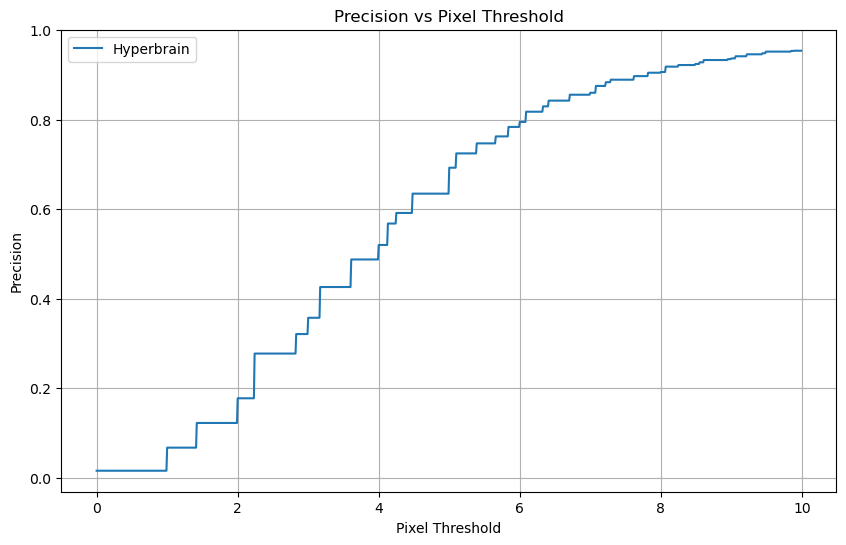

In [ ]:
from source.visualization.evaluation_visualization import plot_precision_vs_threshold
plot_precision_vs_threshold(
    evaluation_metrics["2"]["match_precision"],
    labels=["Hyperbrain"],
)